# Group project - Calf health

This project aims to develop a predictive model to assess the **likelihood of calves becoming sick** based on various features from multiple data sources. By analyzing blood sample data, slaughterhouse records, individual treatment histories, and additional relevant factors, the model seeks to identify patterns and insights that can inform interventions and improve calf health management practices.

## Importing required libraries

The necessary libraries for data manipulation, machine learning, and evaluation metrics are imported:

In [441]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("pandas version:", pd.__version__)            # version used: 2.2.3
print("seaborn version:", sns.__version__)            # version used: 0.13.2
print("matplotlib version:", plt.matplotlib.__version__)       # version used: 3.9.2
print("pyreadstat version:", pyreadstat.__version__)  # version used: 1.2.7
print("numpy version:", np.__version__)       # version used: 2.1.1
print("sklearn version:", sklearn.__version__)       # version used: 1.5.2

pandas version: 2.2.2
seaborn version: 0.13.2
matplotlib version: 3.9.2
pyreadstat version: 1.2.8
numpy version: 2.1.1
sklearn version: 1.5.2


## Global variables for farm files

In [442]:
antens_farm = 'Antens structured data.xlsx'
stagri_farm = 'Stagri structured data.xlsx'
borne_farm = 'Borne structured data.xlsx'

## Data processing and preparation methods

In this section, the methods employed to process and prepare the datasets for analysis are outlined. The primary objective is to **create a comprehensive dataset** that integrates various sources of information related to calf health, including blood sample results, slaughterhouse data, individual treatment records, and additional features such as arrival weights and genetic details.

Each method focuses on loading, filtering, and merging relevant datasets.

### Loading blood and slaughterhouse data
The `load_group_data` function loads two key datasheets from an Excel file: one containing **blood sample data**, where hemoglobin and serum iron values are measured multiple times over several weeks/months, and another containing **slaughterhouse (SLH) data** from calves. A unique identifier for each calf is created (in the blood sample data) by combining its country and life number, allowing for accurate merging with other datasets.

In [443]:
def load_group_data(file, name_blood, name_slh):
    df_blood = pd.read_excel(file, sheet_name=name_blood)
    df_slh = pd.read_excel(file, sheet_name=name_slh)
    df_blood['cow_id'] = df_blood['Land'] + ' ' + df_blood['Levensnr'].astype(str)
    return df_blood, df_slh

### Identifying matching calf IDs
The `get_same_cows_ids` function identifies calf IDs that are present in both the blood sample and slaughterhouse (SLH) datasets. This ensures that subsequent analysis includes only calves for whom **both** types of data are available.


In [444]:
def get_same_cows_ids(df_blood, df_slh):
    cow_ids_blood = set(df_blood['cow_id'])
    cow_ids_slh = set(df_slh['ID nummer'])
    return  cow_ids_blood.intersection(cow_ids_slh)

### Combining data for matching calves
The `combine_matching_cows` function merges the blood sample dataset and the slaughterhouse (SLH) dataset based on the matching calf IDs identified earlier.

In [445]:
def combine_matching_cows(df_blood, df_slh, same_cows_ids):
    df_blood_filtered = df_blood[df_blood['cow_id'].isin(same_cows_ids)]
    df_slh_filtered = df_slh[df_slh['ID nummer'].isin(same_cows_ids)]
    
    df_combined = pd.merge(df_blood_filtered, df_slh_filtered, left_on='cow_id', right_on='ID nummer', how='inner')
    
    return df_combined

### Loading stallijst data
The `load_stallijst_data` function loads additional calf-related data from a stallijst sheet in the Excel file. This dataset includes important features such as fur color and the number of days spent at the veal farm, which may be relevant for predicting the health outcomes of the calves.

In [446]:
def load_stallijst_data(file, name_stallijst):
    df_stallijst = pd.read_excel(file, sheet_name=name_stallijst)
    
    return df_stallijst

### Combining stallijst data with combined dataset
The `combine_stallijst` function merges the previously combined dataset (blood + SLH) with the stallijst data using the calf ID as the key. This step enhances the dataset by adding further relevant information about each calf, providing a richer context for analysis.

In [447]:
def combine_stallijst(df_combined, df_stallijst):
    df_final_combined = pd.merge(df_combined, df_stallijst, left_on='Levensnr', right_on='Calf ID', how='inner')
    
    return df_final_combined

### Loading arrival weights data
The `load_arrival_weights` function retrieves data on the weights of calves upon their arrival at the veal farm. This dataset also includes details such as arrival dates and merchant information, which can be significant for understanding calf health. For instance, the length of time a calf spent at the dairy farm—potentially extended due to prior illness—can be inferred from the arrival date.

In [448]:
def load_arrival_weights(file, name_arrival_weights):
    df_arrival_weights = pd.read_excel(file, sheet_name=name_arrival_weights)
    
    return df_arrival_weights

### Adding arrival weight data
The `add_arrival_weight` function merges the combined dataset (blood + SLH + stallijst) with the arrival weights data based on matching arrival dates and merchant details. This step enhances the dataset by adding further relevant information about each calf, providing a richer context for analysis.

In [449]:
def add_arrival_weight(df_existing, df_arrival_weights):
    df_merged = pd.merge(df_existing, df_arrival_weights[['Stable', 'Handelaar', 'Arrival date', 'Arrival weight']],
                         left_on=['Merchant', 'Arrival Date at Veal Farm'],
                         right_on=['Handelaar', 'Arrival date'],
                         how='left')
    
    return df_merged

### Loading individual treatments data
The `load_individual_treatments` function retrieves data on the individual treatments administered to calves, including the corresponding treatment dates. This information is vital for predicting the health status of each calf, as it provides the target value indicating which calves became sick and which did not.

In [450]:
def load_individual_treatments(file, name_individual_treatments):
    df_individual_treatments = pd.read_excel(file, sheet_name=name_individual_treatments)
    
    return df_individual_treatments

### Adding sick status to the dataset
The `add_sick_status` function assesses the treatment data to identify whether each calf has been sick. It does this by determining the earliest recorded treatment date for each calf and labeling them as `Sick` (1) if they have a treatment date or `Not Sick` (0) otherwise. This new target variable (added to the combined dataset) is essential for training the predictive model, as it indicates the health outcomes to be predicted.

In [451]:
def add_sick_status(df_existing, df_individual_treatments):
    df_individual_treatments['Datum'] = pd.to_datetime(df_individual_treatments['Datum'], errors='coerce')
    
    df_earliest_sickness = df_individual_treatments.groupby('Lev.nr')['Datum'].min().reset_index()
    
    df_merged = pd.merge(df_existing, df_earliest_sickness, left_on='Calf ID + Country', right_on='Lev.nr', how='left')
    
    df_merged['Sick'] = df_merged['Datum'].apply(lambda x: 1 if pd.notna(x) else 0)
    
    df_merged.rename(columns={'Datum': 'Sickness Date'}, inplace=True)
    
    return df_merged

## Finding duplicated columns for cleaning the dataframe
In order to prepare the data to be trained and further analyzed it is needed to drop all the duplicated columns.

In [452]:
def find_duplicate_columns(df):
    duplicates = {}
    
    for i in range(len(df.columns)):
        col1 = df.columns[i]
        for j in range(i + 1, len(df.columns)):
            col2 = df.columns[j]
            if df[col1].equals(df[col2]):
                if col1 in duplicates:
                    duplicates[col1].append(col2)
                else:
                    duplicates[col1] = [col2]
    
    return duplicates

# Antens farm

## Group 2348201

In [453]:
df_blood_2348201, df_slh_2348201 = load_group_data(
    antens_farm,
    name_blood='Group 2348201 - blood samples', 
    name_slh='Group 2348201 Slaughterhouse'
)

In [454]:
same_cows_2348201 = get_same_cows_ids(df_blood_2348201, df_slh_2348201)

In [455]:
len(same_cows_2348201)

549

**There are 549 same cows in both datasets**

## Group 2242208

In [456]:
df_blood_2242208, df_slh_2242208 = load_group_data(
    antens_farm,
    name_blood='Group 2242208 - blood samples',
    name_slh='Group 2242208 Slaughterhouse'
)

In [457]:
same_cows_2242208 = get_same_cows_ids(df_blood_2242208, df_slh_2242208)

In [458]:
len(same_cows_2242208)

491

**There are 491 same cows in both datasets**

## Group 2211207 

In [459]:
df_blood_2211207, df_slh_2211207 = load_group_data(
    antens_farm,
    name_blood='Group 2211207 - blood samples',
    name_slh='Group 2211207 Slaughterhouse',
)

In [460]:
same_cows_2211207 = get_same_cows_ids(df_blood_2211207, df_slh_2211207)

In [461]:
len(same_cows_2211207)

91

**There are 91 same cows in both datasets**

## Group 2133206

In [462]:
df_blood_2133206, df_slh_2133206 = load_group_data(
    antens_farm,
    name_blood='Group 2133206 - blood samples',
    name_slh='Group 2133206 Slaughterhouse',
)

In [463]:
same_cows_2133206 = get_same_cows_ids(df_blood_2133206, df_slh_2133206) 

In [464]:
len(same_cows_2133206)

511

**There are 511 same cows in both datasets**

## Concatenate groups

In [465]:
df_blood_2133206['group'] = 2133206
df_blood_2211207['group'] = 2211207
df_blood_2242208['group'] = 2242208
df_blood_2348201['group'] = 2348201

In [466]:
antens_cows = pd.concat(
    [df_blood_2133206, df_blood_2211207, df_blood_2242208, df_blood_2348201],
    axis=0, ignore_index=True
).dropna(axis=1, how='all').fillna(-1)

## Load Stallijst data

In [467]:
group_2133206_stallijst = load_stallijst_data(antens_farm,name_stallijst='Group 2133206 - Stallijst')
group_2211207_stallijst = load_stallijst_data(antens_farm, name_stallijst='Group 2211207 - Stallijst')
group_2242208_stallijst = load_stallijst_data(antens_farm, name_stallijst = 'Group 2242208 - Stallijst')
group_234201_stallijst = load_stallijst_data(antens_farm, name_stallijst = 'Group 2348201 - Stallijst')

antens_stallijst = pd.concat([group_2133206_stallijst, group_2211207_stallijst, group_2242208_stallijst, group_234201_stallijst], ignore_index=True)

antens_cows = combine_stallijst(antens_cows, antens_stallijst)

antens_cows.head()

,Land,Levensnr,HB1,HB2,HB3,HB4,S2,S3,S4,cow_id,...,Calf ID,Calf ID + Country,Country ID,Birth date,Merchant,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm
0,NL,646244275,5.8,5.8,-1.0,-1.0,0.0,-1.0,-1.0,NL 646244275,...,646244275,NL646244275,NL,2021-08-05,W. Nicolay BV,V,Z,Zwartbont,2021-08-20,15
1,DE,124145148,7.3,6.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 124145148,...,124145148,DE0124145148,DE,2021-07-26,A.J. van Dam,V,A,Eenkleurig zwart,2021-08-18,23
2,DE,363256149,8.3,6.5,-1.0,-1.0,0.0,-1.0,-1.0,DE 363256149,...,363256149,DE0363256149,DE,2021-08-01,A.J. van Dam,V,A,Eenkleurig zwart,2021-08-18,17
3,DE,124278815,6.5,6.1,-1.0,-1.0,0.0,-1.0,-1.0,DE 124278815,...,124278815,DE0124278815,DE,2021-07-26,A.J. van Dam,V,O,Eenkleurig rood,2021-08-18,23
4,DE,362553415,7.3,4.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 362553415,...,362553415,DE0362553415,DE,2021-08-02,A.J. van Dam,V,U,Eenkleurig bruin,2021-08-18,16


## Load arrival weights

In [468]:
antens_arrival_weights = load_arrival_weights(antens_farm, name_arrival_weights = 'Arrival Weights')

antens_cows = add_arrival_weight(antens_cows, antens_arrival_weights)

antens_cows.head()

,Land,Levensnr,HB1,HB2,HB3,HB4,S2,S3,S4,cow_id,...,Merchant,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm,Stable,Handelaar,Arrival date,Arrival weight
0,NL,646244275,5.8,5.8,-1.0,-1.0,0.0,-1.0,-1.0,NL 646244275,...,W. Nicolay BV,V,Z,Zwartbont,2021-08-20,15,Antens,W. Nicolay BV,2021-08-20,46.69
1,DE,124145148,7.3,6.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 124145148,...,A.J. van Dam,V,A,Eenkleurig zwart,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00
2,DE,363256149,8.3,6.5,-1.0,-1.0,0.0,-1.0,-1.0,DE 363256149,...,A.J. van Dam,V,A,Eenkleurig zwart,2021-08-18,17,Antens,A.J. van Dam,2021-08-18,48.00
3,DE,124278815,6.5,6.1,-1.0,-1.0,0.0,-1.0,-1.0,DE 124278815,...,A.J. van Dam,V,O,Eenkleurig rood,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00
4,DE,362553415,7.3,4.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 362553415,...,A.J. van Dam,V,U,Eenkleurig bruin,2021-08-18,16,Antens,A.J. van Dam,2021-08-18,48.00


## Treatments data

In [469]:
treatments_df = pd.read_excel(antens_farm, sheet_name='Treatments', header=None)
print(treatments_df.shape)
treatments_df.head(4)

(10422, 10)


,0,1,2,3,4,5,6,7,8,9
0,2021-08-18 00:00:00,dexa-ject,3505,DE 0124103505,NaN,2.0,ml(cc),15.0,dagen,2021-09-02 00:00:00
1,NaN,NaN,NL112615,NaN,(1x),NaN,NaN,NaN,NaN,NaN
2,2021-08-18 00:00:00,depoceline,3505,DE 0124103505,NaN,6.0,ml(cc),15.0,dagen,2021-09-04 00:00:00
3,NaN,NaN,NL4259,NaN,(3 x 24uur),NaN,NaN,NaN,NaN,NaN


In [470]:
treatments_cleaned = treatments_df.iloc[::2, :]
treatments_cleaned.loc[:, 0] = pd.to_datetime(treatments_cleaned[0])

treatments_cleaned.head()

,0,1,2,3,4,5,6,7,8,9
0,2021-08-18 00:00:00,dexa-ject,3505,DE 0124103505,NaN,2.0,ml(cc),15.0,dagen,2021-09-02 00:00:00
2,2021-08-18 00:00:00,depoceline,3505,DE 0124103505,NaN,6.0,ml(cc),15.0,dagen,2021-09-04 00:00:00
4,2021-08-18 00:00:00,dexa-ject,3754,DE 0124403754,NaN,2.0,ml(cc),15.0,dagen,2021-09-02 00:00:00
6,2021-08-18 00:00:00,depoceline,3754,DE 0124403754,NaN,6.0,ml(cc),15.0,dagen,2021-09-04 00:00:00
8,2021-08-18 00:00:00,micotil,5161,DE 1270605161,NaN,2.0,ml(cc),15.0,dagen,2021-09-02 00:00:00


In [471]:
columns_to_drop = [2, 4, 6, 8]

existing_columns_to_drop = [col for col in columns_to_drop if col in treatments_cleaned.columns]
print(f"Columns to drop that exist in DataFrame: {existing_columns_to_drop}")

treatments_cleaned = treatments_cleaned.drop(columns=existing_columns_to_drop)

treatments_cleaned.columns


Columns to drop that exist in DataFrame: [2, 4, 6, 8]


Index([0, 1, 3, 5, 7, 9], dtype='int64')

In [472]:
columns_naming = {
    0: 'date_and_time_of_treatment',
    1: 'drug',
    3: 'calf_id',
    5: 'dosage', 
    7: 'days',
    9: 'treatment_end_date'
}

treatments_cleaned = treatments_cleaned.rename(columns=columns_naming)

treatments_cleaned.head()

,date_and_time_of_treatment,drug,calf_id,dosage,days,treatment_end_date
0,2021-08-18 00:00:00,dexa-ject,DE 0124103505,2.0,15.0,2021-09-02 00:00:00
2,2021-08-18 00:00:00,depoceline,DE 0124103505,6.0,15.0,2021-09-04 00:00:00
4,2021-08-18 00:00:00,dexa-ject,DE 0124403754,2.0,15.0,2021-09-02 00:00:00
6,2021-08-18 00:00:00,depoceline,DE 0124403754,6.0,15.0,2021-09-04 00:00:00
8,2021-08-18 00:00:00,micotil,DE 1270605161,2.0,15.0,2021-09-02 00:00:00


In [473]:
antens_cows['Calf ID + Country'] = antens_cows['Calf ID + Country'].astype(str)
treatments_cleaned['calf_id'] = treatments_cleaned['calf_id'].astype(str)

antens_cows = pd.merge(antens_cows, treatments_cleaned[['calf_id']], 
                    left_on='Calf ID + Country', right_on='calf_id', how='left')

antens_cows['Sick'] = antens_cows['calf_id'].apply(lambda x: 1 if pd.notna(x) else 0)## 

antens_cows.drop(columns=['calf_id'], inplace=True)

antens_cows.head()


,Land,Levensnr,HB1,HB2,HB3,HB4,S2,S3,S4,cow_id,...,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm,Stable,Handelaar,Arrival date,Arrival weight,Sick
0,NL,646244275,5.8,5.8,-1.0,-1.0,0.0,-1.0,-1.0,NL 646244275,...,V,Z,Zwartbont,2021-08-20,15,Antens,W. Nicolay BV,2021-08-20,46.69,0
1,DE,124145148,7.3,6.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 124145148,...,V,A,Eenkleurig zwart,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0
2,DE,363256149,8.3,6.5,-1.0,-1.0,0.0,-1.0,-1.0,DE 363256149,...,V,A,Eenkleurig zwart,2021-08-18,17,Antens,A.J. van Dam,2021-08-18,48.00,0
3,DE,124278815,6.5,6.1,-1.0,-1.0,0.0,-1.0,-1.0,DE 124278815,...,V,O,Eenkleurig rood,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0
4,DE,362553415,7.3,4.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 362553415,...,V,U,Eenkleurig bruin,2021-08-18,16,Antens,A.J. van Dam,2021-08-18,48.00,0


## Adding season features

In [474]:
antens_cows['Birth date'] = pd.to_datetime(antens_cows['Birth date'], dayfirst=True)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

antens_cows['Season'] = antens_cows['Birth date'].dt.month.apply(get_season)

antens_cows['Season_Born'] = pd.factorize(antens_cows['Season'])[0]

antens_cows.head()

,Land,Levensnr,HB1,HB2,HB3,HB4,S2,S3,S4,cow_id,...,Fur color,Arrival Date at Veal Farm,Days at diary farm,Stable,Handelaar,Arrival date,Arrival weight,Sick,Season,Season_Born
0,NL,646244275,5.8,5.8,-1.0,-1.0,0.0,-1.0,-1.0,NL 646244275,...,Zwartbont,2021-08-20,15,Antens,W. Nicolay BV,2021-08-20,46.69,0,Summer,0
1,DE,124145148,7.3,6.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 124145148,...,Eenkleurig zwart,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
2,DE,363256149,8.3,6.5,-1.0,-1.0,0.0,-1.0,-1.0,DE 363256149,...,Eenkleurig zwart,2021-08-18,17,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
3,DE,124278815,6.5,6.1,-1.0,-1.0,0.0,-1.0,-1.0,DE 124278815,...,Eenkleurig rood,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
4,DE,362553415,7.3,4.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 362553415,...,Eenkleurig bruin,2021-08-18,16,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0


## Cleaning the dataframe

In [475]:
columns_to_drop = ['Levensnr', 'Land', 'Calf ID']

existing_columns_to_drop = [col for col in columns_to_drop if col in antens_cows.columns]
print(f"Columns to drop that exist in DataFrame: {existing_columns_to_drop}")

if existing_columns_to_drop:
    antens_cows = antens_cows.drop(columns=existing_columns_to_drop)
    print(f"Dropped columns: {existing_columns_to_drop}")
else:
    print("No matching columns found to drop.")

antens_cows.head()


Columns to drop that exist in DataFrame: ['Levensnr', 'Land', 'Calf ID']
Dropped columns: ['Levensnr', 'Land', 'Calf ID']


,HB1,HB2,HB3,HB4,S2,S3,S4,cow_id,group,Calf ID + Country,...,Fur color,Arrival Date at Veal Farm,Days at diary farm,Stable,Handelaar,Arrival date,Arrival weight,Sick,Season,Season_Born
0,5.8,5.8,-1.0,-1.0,0.0,-1.0,-1.0,NL 646244275,2133206,NL646244275,...,Zwartbont,2021-08-20,15,Antens,W. Nicolay BV,2021-08-20,46.69,0,Summer,0
1,7.3,6.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 124145148,2133206,DE0124145148,...,Eenkleurig zwart,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
2,8.3,6.5,-1.0,-1.0,0.0,-1.0,-1.0,DE 363256149,2133206,DE0363256149,...,Eenkleurig zwart,2021-08-18,17,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
3,6.5,6.1,-1.0,-1.0,0.0,-1.0,-1.0,DE 124278815,2133206,DE0124278815,...,Eenkleurig rood,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
4,7.3,4.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 362553415,2133206,DE0362553415,...,Eenkleurig bruin,2021-08-18,16,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0


In [476]:
antens_cows['Merchant'] = pd.factorize(antens_cows['Merchant'])[0]
antens_cows['Sex'] = pd.factorize(antens_cows['Sex'])[0]
antens_cows['Country ID'] = pd.factorize(antens_cows['Country ID'])[0]
antens_cows['Fur color'] = pd.factorize(antens_cows['Fur color'])[0]
antens_cows['group'] = pd.factorize(antens_cows['group'])[0]

antens_cows.head(5)

,HB1,HB2,HB3,HB4,S2,S3,S4,cow_id,group,Calf ID + Country,...,Fur color,Arrival Date at Veal Farm,Days at diary farm,Stable,Handelaar,Arrival date,Arrival weight,Sick,Season,Season_Born
0,5.8,5.8,-1.0,-1.0,0.0,-1.0,-1.0,NL 646244275,0,NL646244275,...,0,2021-08-20,15,Antens,W. Nicolay BV,2021-08-20,46.69,0,Summer,0
1,7.3,6.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 124145148,0,DE0124145148,...,1,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
2,8.3,6.5,-1.0,-1.0,0.0,-1.0,-1.0,DE 363256149,0,DE0363256149,...,1,2021-08-18,17,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
3,6.5,6.1,-1.0,-1.0,0.0,-1.0,-1.0,DE 124278815,0,DE0124278815,...,2,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
4,7.3,4.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 362553415,0,DE0362553415,...,3,2021-08-18,16,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0


## Translation and new column order

In [477]:
translation_dict = {    'HB1': 'Hemoglobin 1',    'HB2': 'Hemoglobin 2',    'HB3': 'Hemoglobin 3',    'S2': 'Serum 2',    'S3': 'Serum 3',    'Type': 'Type',    'Vetbedekking': 'Fat Covering',    'Kleur': 'Meat Color',    'Gewicht': 'Slaughter Weight',    'Geboorte datum': 'Birth Date',    'Slacht datum': 'Slaughter Date',    'Afwijkingen': 'Abnormalities',    'Calf ID': 'Calf ID',    'Calf ID + Country': 'Country ID + Calf ID',    'County ID': 'Country ID',    'Merchant': 'Merchant',    'Sex': 'Sex',    'Color Letter': 'Color Letter',    'Fur Color': 'Fur Color',    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',    'Days at diary farm': 'Days at Dairy Farm',    'Stable': 'Stable',    'Arrival weight': 'Arrival Weight',    'Sickness Date': 'Sickness Date',    'Sick': 'Sick'}

antens_cows.rename(columns=translation_dict, inplace=True)

antens_cows.head()

,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,HB4,Serum 2,Serum 3,S4,cow_id,group,Country ID + Calf ID,...,Fur color,Arrival Date at Veal Farm,Days at Dairy Farm,Stable,Handelaar,Arrival date,Arrival Weight,Sick,Season,Season_Born
0,5.8,5.8,-1.0,-1.0,0.0,-1.0,-1.0,NL 646244275,0,NL646244275,...,0,2021-08-20,15,Antens,W. Nicolay BV,2021-08-20,46.69,0,Summer,0
1,7.3,6.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 124145148,0,DE0124145148,...,1,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
2,8.3,6.5,-1.0,-1.0,0.0,-1.0,-1.0,DE 363256149,0,DE0363256149,...,1,2021-08-18,17,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
3,6.5,6.1,-1.0,-1.0,0.0,-1.0,-1.0,DE 124278815,0,DE0124278815,...,2,2021-08-18,23,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0
4,7.3,4.9,-1.0,-1.0,0.0,-1.0,-1.0,DE 362553415,0,DE0362553415,...,3,2021-08-18,16,Antens,A.J. van Dam,2021-08-18,48.00,0,Summer,0


In [478]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Birth date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sick', 
    'Season',
    'Season_Born'
]

antens_cows = antens_cows[new_column_order]

antens_cows.sample(5)

,Country ID + Calf ID,Country ID,Birth date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sick,Season,Season_Born
2546,DK05028407685,2,2022-02-26,0,Antens,20,2022-03-18,47.00,6,5,B,5.3,-1.0,-1.0,-1.0,-1.0,0,Winter,1
5017,DK06880305653,2,2023-11-18,1,Antens,20,2023-12-08,47.00,6,7,W,5.5,7.8,5.6,29.0,46.0,0,Autumn,3
5869,DE1505444783,1,2023-10-31,1,Antens,29,2023-11-29,47.00,4,0,Z,5.3,5.1,-1.0,0.0,-1.0,0,Autumn,3
1464,DE0363515639,1,2021-08-05,0,Antens,20,2021-08-25,54.33,3,0,Z,6.3,5.9,-1.0,0.0,-1.0,0,Summer,0
4977,DK03066505001,2,2023-11-21,1,Antens,17,2023-12-08,47.00,6,0,Z,6.2,8.7,-1.0,0.0,-1.0,0,Autumn,3


## Correlation matrix

In [479]:
antens_cows_analysis = antens_cows[['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3', 'Merchant', 'Sex', 'Fur color', 'Country ID', 'Arrival Weight' , 'Fur color', 'Season_Born', 'Sick']]

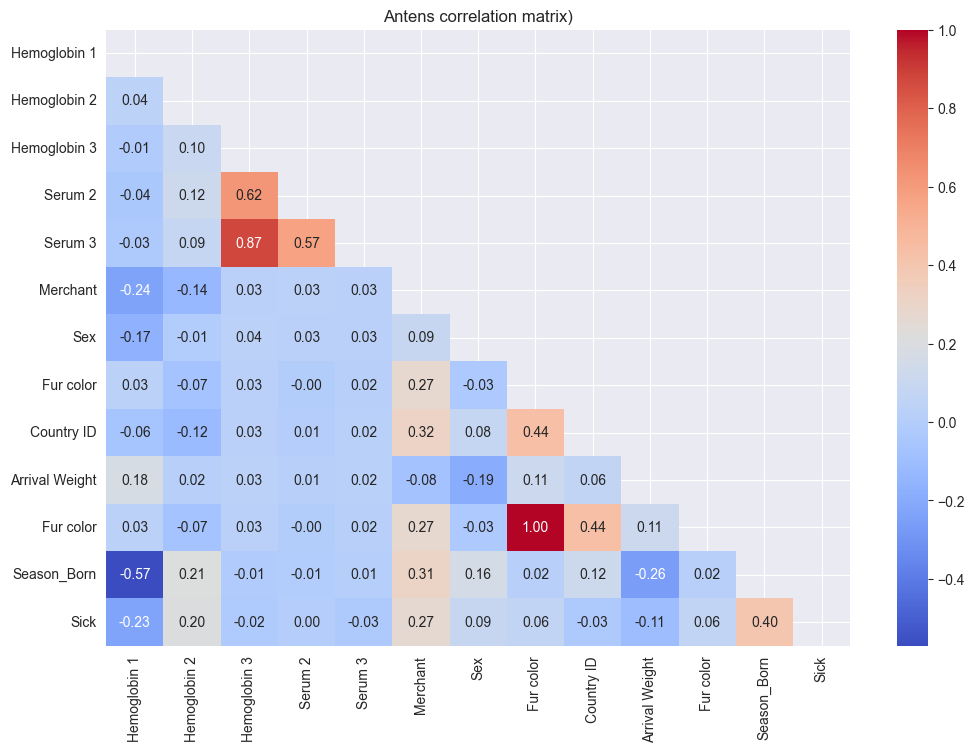

In [480]:
antens_corr = antens_cows_analysis.corr()

mask = np.triu(np.ones_like(antens_corr, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(antens_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Antens correlation matrix)")
plt.show()

In [481]:
# treatments_cleaned['applied_medicine'].value_counts()

## Analyze sick calves

In [482]:
# sick_cows = set(
#     treatments_cleaned[treatments_cleaned['cow_id'].isin(
#         same_cows_2133206 | same_cows_2211207 | same_cows_2242208 | same_cows_2348201
#     )].drop_duplicates(subset='cow_id')['cow_id'].values
# )

In [483]:
# antens_cows['sick'] = antens_cows['cow_id'].apply(lambda cow: 1 if cow in sick_cows else 0)
# antens_cows.head(1)

In [484]:
# # one-hot encoding
# one_hot_encoded = pd.get_dummies(antens_cows['group'], prefix='group')
# antens_cows = pd.concat([antens_cows, one_hot_encoded], axis=1)
# antens_cows.drop('group', axis=1, inplace=True) 
# 
# # one-hot encoding
# one_hot_encoded = pd.get_dummies(antens_cows['Land'], prefix='land')
# antens_cows = pd.concat([antens_cows, one_hot_encoded], axis=1)
# antens_cows.drop('Land', axis=1, inplace=True) 

In [485]:
# antens_cows.columns

In [486]:
# antens_cows = antens_cows[['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
#        'group_2133206', 'group_2211207', 'group_2242208',
#        'group_2348201', 'land_BE', 'land_DE', 'land_DK', 'land_IE', 'land_NL', 'sick']]
# antens_cows.head(1)

In [487]:
# antens_cows.to_csv('antens_cows_features.csv')

## Correlation matrix

In [488]:
# # Compute the correlation matrix
# corr = antens_cows.corr()
# 
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))
# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))
# 
# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# 
# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f",
#  annot=True)
# 
# plt.show()

In [489]:
# antens_cows['sick'].value_counts().plot(kind='bar')
# plt.show()

# Stagri farm

## Group 2338338

In [490]:
df_blood_2338338, df_slh_2338338 = load_group_data(
    stagri_farm,
    name_blood='Group 2338338 - blood samples',
    name_slh='Group 2338338 Slaughterhouse',
)
df_blood_2338338['group'] = 2338338

In [491]:
same_cows_2338338 = get_same_cows_ids(df_blood_2338338, df_slh_2338338) 

In [492]:
len(same_cows_2338338)

898

## Group 2309337

In [493]:
df_blood_2309337, df_slh_2309337 = load_group_data(
    stagri_farm,
    name_blood='Group 2309337 - blood samples',
    name_slh='Group 2309337 Slaughterhouse',
)
df_blood_2309337['group'] = 2309337

In [494]:
same_cows_2309337 = get_same_cows_ids(df_blood_2309337, df_slh_2309337) 

In [495]:
len(same_cows_2309337)

152

## Group 2232336

In [496]:
df_blood_2232336, df_slh_2232336 = load_group_data(
    stagri_farm,
    name_blood='Group 2232336 - blood samples',
    name_slh='Group 2232336 Slaughterhouse',
)
df_blood_2232336['group'] = 2232336

In [497]:
same_cows_2232336 = get_same_cows_ids(df_blood_2232336, df_slh_2232336) 

In [498]:
len(same_cows_2232336)

278

## Group 2128334

In [499]:
df_blood_2128334, df_slh_2128334 = load_group_data(
    stagri_farm,
    name_blood='Group 2128334 - blood samples',
    name_slh='Group 2128334 Slaughterhouse',
)
df_blood_2128334['group'] = 2128334

In [500]:
same_cows_2128334 = get_same_cows_ids(df_blood_2128334, df_slh_2128334)

In [501]:
len(same_cows_2128334)

354

## All groups analysis

### Individual treatments data

In [502]:
treatments_df = load_individual_treatments(stagri_farm, name_individual_treatments='Individual treatments')

treatments_df.head()

,Levensnummer,Werknr,Gesl.,Haarkl.,Geboortedatum,Lft.,Lft. mnd (dgn),Moeder,Ondereindkalf,Aanv.dat.,Herkomst,Aanv. verpl.type,Afv.dat.,Bestemming,Afv. verpl.type
0,FR 5944360075,75,M,ZB,2023-09-03,201,6 (19),FR 5944359835,NaN,2023-09-20,FR,Import,2024-03-22,U2096311,Afvoer
1,FR 5944360076,76,M,ZB,2023-09-04,56,1 (26),FR 6043777289,NaN,2023-09-20,FR,Import,2023-10-30,NaN,Dood
2,FR 7634340105,105,M,ZB,2023-09-04,199,6 (17),FR 7634348996,NaN,2023-09-20,FR,Import,2024-03-21,U2096311,Afvoer
3,DE 1082700126,126,M,ZB,2023-08-06,225,7 (12),DE 1082596376,NaN,2023-09-19,DE,Import,2024-03-18,U2096311,Afvoer
4,FR 5944790164,164,M,ZB,2023-09-02,201,6 (19),FR 5944789812,NaN,2023-09-20,FR,Import,2024-03-21,U2096311,Afvoer


### Combining data

In [503]:
combined_2128334 = combine_matching_cows(df_blood_2128334, df_slh_2128334, same_cows_2128334)
combined_2232336 = combine_matching_cows(df_blood_2232336, df_slh_2232336, same_cows_2232336)
combined_2309337 = combine_matching_cows(df_blood_2309337, df_slh_2309337, same_cows_2309337)
combined_2338338 = combine_matching_cows(df_blood_2338338, df_slh_2338338, same_cows_2338338)

stagri_cows_combined = pd.concat([combined_2128334, combined_2232336, combined_2309337, combined_2338338], ignore_index=True)

stagri_cows_combined.head()

,Land,Levensnr,HB1,HB2,HB3,HB4,HB5,S2,S3,S4,...,Lever,Kalf,Unnamed: 21,Overziener,Antibiotica,Bacteriologie,Prostaat,Spuitnek,Spuitborst,Slacht Datum
0,DE,1406468164,6.5,7.1,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DE,1269784656,6.7,6.6,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DE,1269784653,6.3,6.8,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DE,1269784654,6.6,7,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DE,1406364716,7.0,6.9,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding stallijst data

In [504]:
group_2338338_stallijst = load_stallijst_data(stagri_farm, name_stallijst='Group 2338338 Stallijst')
group_2309337_stallijst = load_stallijst_data(stagri_farm, name_stallijst ='Group 2309337 - Stallijst')
group_2232336_stallijst = load_stallijst_data(stagri_farm, name_stallijst ='Group 2232336 - Stallijst')
group_2128334_stallijst = load_stallijst_data(stagri_farm, name_stallijst='Group 2128334 - Stallijst')

stagri_stallijst_combined = pd.concat([group_2338338_stallijst, group_2309337_stallijst, group_2232336_stallijst, group_2128334_stallijst], ignore_index=True)

stagri_stallijst_combined.head(10)

,Calf ID,Calf ID + Country,Country ID,Birth date,Merchant,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm
0,124647493.0,DE 0124647493,DE,2023-08-19,Boerkamp,S,Z,Zwartbont,2023-09-20,32.0
1,124880144.0,DE 0124880144,DE,2023-07-18,Boerkamp,S,Z,Zwartbont,2023-09-20,64.0
2,124948165.0,DE 0124948165,DE,2023-08-14,Boerkamp,S,Z,Zwartbont,2023-09-20,37.0
3,124988073.0,DE 0124988073,DE,2023-08-21,Boerkamp,S,Z,Zwartbont,2023-09-20,30.0
4,125011296.0,DE 0125011296,DE,2023-08-18,Boerkamp,S,R,Roodbont,2023-09-20,33.0
5,125041330.0,DE 0125041330,DE,2023-08-15,Boerkamp,S,R,Roodbont,2023-09-20,36.0
6,125062532.0,DE 0125062532,DE,2023-08-20,Boerkamp,S,Z,Zwartbont,2023-09-20,31.0
7,125064942.0,DE 0125064942,DE,2023-08-18,Boerkamp,S,Z,Zwartbont,2023-09-20,33.0
8,125065413.0,DE 0125065413,DE,2023-08-14,Boerkamp,S,U,Eenkleurig bruin,2023-09-20,37.0
9,125099617.0,DE 0125099617,DE,2023-08-06,Boerkamp,S,U,Eenkleurig bruin,2023-09-20,45.0


### Adding arrival weight

In [505]:
arrival_weight_stagri = load_arrival_weights(stagri_farm, name_arrival_weights='Arrival weights')

stagri_arrival_stallijst_combined = add_arrival_weight(stagri_stallijst_combined, arrival_weight_stagri)

stagri_arrival_stallijst_combined.head()

,Calf ID,Calf ID + Country,Country ID,Birth date,Merchant,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm,Stable,Handelaar,Arrival date,Arrival weight
0,124647493.0,DE 0124647493,DE,2023-08-19,Boerkamp,S,Z,Zwartbont,2023-09-20,32.0,Stagri,Boerkamp,2023-09-20,48.7
1,124880144.0,DE 0124880144,DE,2023-07-18,Boerkamp,S,Z,Zwartbont,2023-09-20,64.0,Stagri,Boerkamp,2023-09-20,48.7
2,124948165.0,DE 0124948165,DE,2023-08-14,Boerkamp,S,Z,Zwartbont,2023-09-20,37.0,Stagri,Boerkamp,2023-09-20,48.7
3,124988073.0,DE 0124988073,DE,2023-08-21,Boerkamp,S,Z,Zwartbont,2023-09-20,30.0,Stagri,Boerkamp,2023-09-20,48.7
4,125011296.0,DE 0125011296,DE,2023-08-18,Boerkamp,S,R,Roodbont,2023-09-20,33.0,Stagri,Boerkamp,2023-09-20,48.7


### Merging with individual treatments

In [506]:
# I am converting to string to avoid any issues
stagri_cows_combined['cow_id'] = stagri_cows_combined['cow_id'].astype(str)
treatments_df['Levensnummer'] = treatments_df['Levensnummer'].astype(str)

# Added this line 
combined_with_stallijst = combine_stallijst(stagri_cows_combined, stagri_stallijst_combined)

final_df = pd.merge(combined_with_stallijst, treatments_df[['Levensnummer']], 
                    left_on='cow_id', right_on='Levensnummer', how='left')

final_df['Sick'] = final_df['Levensnummer'].apply(lambda x: 1 if pd.notna(x) else 0)## 

# I drop the 'Levensummer' column because I no longer need it
final_df.drop(columns=['Levensnummer'], inplace=True)

stagri_df = final_df

stagri_df.head()


,Land,Levensnr,HB1,HB2,HB3,HB4,HB5,S2,S3,S4,...,Calf ID + Country,Country ID,Birth date,Merchant,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm,Sick
0,DE,1406468164,6.5,7.1,NaN,NaN,NaN,0.0,NaN,NaN,...,DE1406468164,DE,2021-06-08,lochimex,V,U,Eenkleurig bruin,2021-07-14,42.0,0
1,DE,1269784656,6.7,6.6,NaN,NaN,NaN,0.0,NaN,NaN,...,DE1269784656,DE,2021-06-26,lochimex,S,Z,Zwartbont,2021-07-14,51.0,0
2,DE,1269784653,6.3,6.8,NaN,NaN,NaN,0.0,NaN,NaN,...,DE1269784653,DE,2021-06-25,lochimex,S,Z,Zwartbont,2021-07-14,51.0,0
3,DE,1269784654,6.6,7,NaN,NaN,NaN,0.0,NaN,NaN,...,DE1269784654,DE,2021-06-25,lochimex,S,Z,Zwartbont,2021-07-14,49.0,0
4,DE,1406364716,7.0,6.9,NaN,NaN,NaN,0.0,NaN,NaN,...,DE1406364716,DE,2021-06-29,lochimex,V,Z,Zwartbont,2021-07-14,47.0,0


### Adding arrival weight

In [507]:
arrival_weight_stagri = load_arrival_weights(stagri_farm, name_arrival_weights='Arrival weights')

stagri_df = add_arrival_weight(stagri_df, arrival_weight_stagri)

stagri_df.head()

,Land,Levensnr,HB1,HB2,HB3,HB4,HB5,S2,S3,S4,...,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm,Sick,Stable,Handelaar,Arrival date,Arrival weight
0,DE,1406468164,6.5,7.1,NaN,NaN,NaN,0.0,NaN,NaN,...,V,U,Eenkleurig bruin,2021-07-14,42.0,0,Stagri,lochimex,2021-07-14,46.0
1,DE,1269784656,6.7,6.6,NaN,NaN,NaN,0.0,NaN,NaN,...,S,Z,Zwartbont,2021-07-14,51.0,0,Stagri,lochimex,2021-07-14,46.0
2,DE,1269784653,6.3,6.8,NaN,NaN,NaN,0.0,NaN,NaN,...,S,Z,Zwartbont,2021-07-14,51.0,0,Stagri,lochimex,2021-07-14,46.0
3,DE,1269784654,6.6,7,NaN,NaN,NaN,0.0,NaN,NaN,...,S,Z,Zwartbont,2021-07-14,49.0,0,Stagri,lochimex,2021-07-14,46.0
4,DE,1406364716,7.0,6.9,NaN,NaN,NaN,0.0,NaN,NaN,...,V,Z,Zwartbont,2021-07-14,47.0,0,Stagri,lochimex,2021-07-14,46.0


### Adding the season the calves were born in

In [508]:
stagri_df['Birth date'] = pd.to_datetime(stagri_df['Birth date'], dayfirst=True)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

stagri_df['Season'] = stagri_df['Birth date'].dt.month.apply(get_season)

stagri_df['Season_Born'] = pd.factorize(stagri_df['Season'])[0]

stagri_df.head()

,Land,Levensnr,HB1,HB2,HB3,HB4,HB5,S2,S3,S4,...,Fur color,Arrival Date at Veal Farm,Days at diary farm,Sick,Stable,Handelaar,Arrival date,Arrival weight,Season,Season_Born
0,DE,1406468164,6.5,7.1,NaN,NaN,NaN,0.0,NaN,NaN,...,Eenkleurig bruin,2021-07-14,42.0,0,Stagri,lochimex,2021-07-14,46.0,Summer,0
1,DE,1269784656,6.7,6.6,NaN,NaN,NaN,0.0,NaN,NaN,...,Zwartbont,2021-07-14,51.0,0,Stagri,lochimex,2021-07-14,46.0,Summer,0
2,DE,1269784653,6.3,6.8,NaN,NaN,NaN,0.0,NaN,NaN,...,Zwartbont,2021-07-14,51.0,0,Stagri,lochimex,2021-07-14,46.0,Summer,0
3,DE,1269784654,6.6,7,NaN,NaN,NaN,0.0,NaN,NaN,...,Zwartbont,2021-07-14,49.0,0,Stagri,lochimex,2021-07-14,46.0,Summer,0
4,DE,1406364716,7.0,6.9,NaN,NaN,NaN,0.0,NaN,NaN,...,Zwartbont,2021-07-14,47.0,0,Stagri,lochimex,2021-07-14,46.0,Summer,0


### Cleaning the data

In [509]:
duplicate_columns = find_duplicate_columns(stagri_df)

for col, dupes in duplicate_columns.items():
    print(f"Column '{col}' has duplicates: {dupes}")
    
columns_to_drop = set()
for dupes in duplicate_columns.values():
    columns_to_drop.update(dupes) 

stagri_df = stagri_df.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")

stagri_df.head(10)

Column 'HB5' has duplicates: ['S5', 'Haarkleur', 'Hoofd', 'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart', 'Nieren', 'Lever', 'Kalf', 'Unnamed: 21', 'Overziener', 'Antibiotica', 'Bacteriologie', 'Prostaat', 'Spuitnek', 'Spuitborst']
Column 'S5' has duplicates: ['Haarkleur', 'Hoofd', 'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart', 'Nieren', 'Lever', 'Kalf', 'Unnamed: 21', 'Overziener', 'Antibiotica', 'Bacteriologie', 'Prostaat', 'Spuitnek', 'Spuitborst']
Column 'Haarkleur' has duplicates: ['Hoofd', 'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart', 'Nieren', 'Lever', 'Kalf', 'Unnamed: 21', 'Overziener', 'Antibiotica', 'Bacteriologie', 'Prostaat', 'Spuitnek', 'Spuitborst']
Column 'cow_id' has duplicates: ['ID nummer']
Column 'Hoofd' has duplicates: ['Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart', 'Nieren', 'Lever', 'Kalf', 'Unnamed: 21', 'Overziener', 'Antibiotica', 'Bacteriologie', 'Prostaat', 'Spuitnek', 'Spuitborst']


,Land,Levensnr,HB1,HB2,HB3,HB4,HB5,S2,S3,S4,...,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm,Sick,Stable,Arrival weight,Season,Season_Born
0,DE,1406468164,6.5,7.1,NaN,NaN,NaN,0.0,NaN,NaN,...,V,U,Eenkleurig bruin,2021-07-14,42.0,0,Stagri,46.0,Summer,0
1,DE,1269784656,6.7,6.6,NaN,NaN,NaN,0.0,NaN,NaN,...,S,Z,Zwartbont,2021-07-14,51.0,0,Stagri,46.0,Summer,0
2,DE,1269784653,6.3,6.8,NaN,NaN,NaN,0.0,NaN,NaN,...,S,Z,Zwartbont,2021-07-14,51.0,0,Stagri,46.0,Summer,0
3,DE,1269784654,6.6,7,NaN,NaN,NaN,0.0,NaN,NaN,...,S,Z,Zwartbont,2021-07-14,49.0,0,Stagri,46.0,Summer,0
4,DE,1406364716,7.0,6.9,NaN,NaN,NaN,0.0,NaN,NaN,...,V,Z,Zwartbont,2021-07-14,47.0,0,Stagri,46.0,Summer,0
5,DE,1504736577,5.6,6.2,NaN,NaN,NaN,0.0,NaN,NaN,...,V,Z,Zwartbont,2021-07-14,51.0,0,Stagri,46.0,Summer,0
6,DE,1406467306,4.6,6,NaN,NaN,NaN,0.0,NaN,NaN,...,S,Z,Zwartbont,2021-07-14,42.0,0,Stagri,46.0,Summer,0
7,DE,1406571204,5.0,6.7,NaN,NaN,NaN,0.0,NaN,NaN,...,S,U,Eenkleurig bruin,2021-07-14,44.0,0,Stagri,46.0,Summer,0
8,DE,1406367971,6.0,6.7,NaN,NaN,NaN,0.0,NaN,NaN,...,S,Z,Zwartbont,2021-07-14,43.0,0,Stagri,46.0,Summer,0
9,DE,1406520014,5.3,6.6,NaN,NaN,NaN,0.0,NaN,NaN,...,S,U,Eenkleurig bruin,2021-07-14,48.0,0,Stagri,46.0,Summer,0


In [510]:
columns_to_clean = ['HB3', 'HB4', 'HB5', 'S3', 'S4']
stagri_df[columns_to_clean] =stagri_df[columns_to_clean].fillna(0.0)

stagri_df['Slacht Datum'] = stagri_df['Slacht Datum'].fillna(0.0)

stagri_df['Merchant'] = pd.factorize(stagri_df['Merchant'])[0]
stagri_df['Sex'] = pd.factorize(stagri_df['Sex'])[0]
stagri_df['Country ID'] = pd.factorize(stagri_df['Country ID'])[0]
stagri_df['Fur color'] = pd.factorize(stagri_df['Fur color'])[0]
stagri_df['group'] = pd.factorize(stagri_df['group'])[0]


columns_to_drop = ['Levensnr', 'WerkNr', '#', 'Soort', 'Kleur', 'Vet', 
                   'Geboortedatum', 'Leeftijdscode', 'Sekse']

# I had before that 'stagri_df.drop(...)
# This doesn't work because I need to reassign the stagri_df to the new one
stagri_df = stagri_df.drop(columns=columns_to_drop, errors='ignore')

stagri_df.head(5)

,Land,HB1,HB2,HB3,HB4,HB5,S2,S3,S4,cow_id,...,Sex,Color Letter,Fur color,Arrival Date at Veal Farm,Days at diary farm,Sick,Stable,Arrival weight,Season,Season_Born
0,DE,6.5,7.1,0.0,0.0,0.0,0.0,0.0,0.0,DE 1406468164,...,0,U,0,2021-07-14,42.0,0,Stagri,46.0,Summer,0
1,DE,6.7,6.6,0.0,0.0,0.0,0.0,0.0,0.0,DE 1269784656,...,1,Z,1,2021-07-14,51.0,0,Stagri,46.0,Summer,0
2,DE,6.3,6.8,0.0,0.0,0.0,0.0,0.0,0.0,DE 1269784653,...,1,Z,1,2021-07-14,51.0,0,Stagri,46.0,Summer,0
3,DE,6.6,7,0.0,0.0,0.0,0.0,0.0,0.0,DE 1269784654,...,1,Z,1,2021-07-14,49.0,0,Stagri,46.0,Summer,0
4,DE,7.0,6.9,0.0,0.0,0.0,0.0,0.0,0.0,DE 1406364716,...,0,Z,1,2021-07-14,47.0,0,Stagri,46.0,Summer,0


### Translation and new column order

In [511]:
translation_dict = {    'HB1': 'Hemoglobin 1',    'HB2': 'Hemoglobin 2',    'HB3': 'Hemoglobin 3',    'S2': 'Serum 2',    'S3': 'Serum 3',    'Type': 'Type',    'Vetbedekking': 'Fat Covering',    'Kleur': 'Meat Color',    'Gewicht': 'Slaughter Weight',    'Geboorte datum': 'Birth Date',    'Slacht datum': 'Slaughter Date',    'Afwijkingen': 'Abnormalities',    'Calf ID': 'Calf ID',    'Calf ID + Country': 'Country ID + Calf ID',    'County ID': 'Country ID',    'Merchant': 'Merchant',    'Sex': 'Sex',    'Color Letter': 'Color Letter',    'Fur Color': 'Fur Color',    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',    'Days at diary farm': 'Days at Dairy Farm',    'Stable': 'Stable',    'Arrival weight': 'Arrival Weight',    'Sickness Date': 'Sickness Date',    'Sick': 'Sick'}

stagri_df.rename(columns=translation_dict, inplace=True)

stagri_df.columns

Index(['Land', 'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'HB4', 'HB5',
       'Serum 2', 'Serum 3', 'S4', 'cow_id', 'group', 'Slaughter Weight',
       'Slacht Datum', 'Calf ID', 'Country ID + Calf ID', 'Country ID',
       'Birth date', 'Merchant', 'Sex', 'Color Letter', 'Fur color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Sick', 'Stable',
       'Arrival Weight', 'Season', 'Season_Born'],
      dtype='object')

In [512]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sick', 
    'Slaughter Weight',
    'Season',
    'Season_Born'
]

stagri_df = stagri_df[new_column_order]

stagri_df.sample(5)

,Country ID + Calf ID,Country ID,Calf ID,Birth date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,...,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sick,Slaughter Weight,Season,Season_Born
605,LU 418155099,2,4.181551e+08,2022-07-21,1,Stagri,27.0,2022-08-17,48.0,3,...,R,7.3,6.8,0.0,0.0,0.0,0,170.4,Summer,0
1223,FR 6045064968,4,6.045065e+09,2023-08-30,1,Stagri,21.0,2023-09-20,49.7,0,...,Z,4.2,5.3,0.0,0.0,0.0,1,151.0,Summer,0
989,FR 6208482719,4,6.208483e+09,2023-08-27,1,Stagri,24.0,2023-09-20,49.7,0,...,Z,5.8,5.6,0.0,0.0,0.0,1,151.1,Summer,0
378,DE 1406790134,0,1.406790e+09,2022-07-22,0,Stagri,19.0,2022-08-10,50.0,1,...,R,7.4,6.2,5.3,49.0,22.0,0,134.4,Summer,0
282,DE1270663530,0,1.270664e+09,2021-07-06,1,Stagri,48.0,2021-07-20,48.0,3,...,Z,4.8,5,0.0,0.0,0.0,0,143.6,Summer,0


### Group and Land features
Since in the file there are a lot of calves that are coming from a different land I am separating all the lands in a different feature to be able to have extra features and further understanding in my correlation matrix. E.g. Maybe all sick calves actually are french so this could lead to further analysis.

Same goes for the 'group' feature. I have combined 5 groups in this file and I want to indicate in which group the calf was. This was created again for possible further analysis in the future.

In [513]:
# # Creating a unique value in the group column, 'prefix-group' adds the unique values after the group
# one_hot_encoding = pd.get_dummies(stagri_df['group'], prefix='group')
# 
# #Concatenates the new column to the final_df
# stagri_df = pd.concat([stagri_df, one_hot_encoding], axis=1)
# 
# # After that we drop the original one
# stagri_df.drop('group', axis=1, inplace=True)
# 
# one_hot_encoding = pd.get_dummies(stagri_df['Land'], prefix='land')
# stagri_df = pd.concat([stagri_df, one_hot_encoding], axis=1)
# stagri_df.drop('Land', axis=1, inplace=True)
# 
# stagri_df.head(10)
# 
# # stagri_df.to_excel('Final.xlsx',index=False)

In [514]:
stagri_cows = stagri_df[['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3', 'Merchant', 'Sex', 'Fur color', 'Country ID', 'Arrival Weight' , 'Fur color' , 'Slaughter Weight', 'Season_Born', 'Sick']]

### Correlation matrix

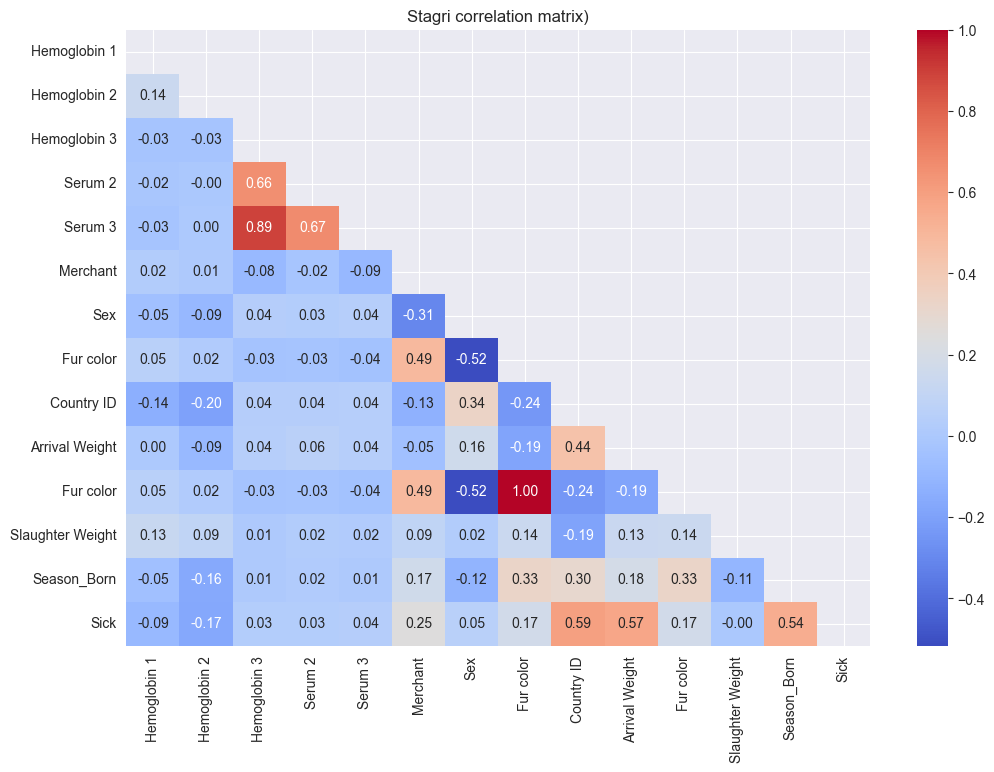

In [515]:
stagri_corr = stagri_cows.corr()

mask = np.triu(np.ones_like(stagri_corr, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(stagri_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Stagri correlation matrix)")
plt.show()

# Borne farm

One of the three farms from which Maarten (our client) has provided data is the `Borne` farm. In this section, the data for each group of calves is analyzed to identify correlations between the available features and the likelihood of illness. The goal is to develop a predictive model for calf health.

While most data is consistent across the different groups, there are exceptions in the **slaughter data**, where two datasheets are available for some groups with differing features. As a result, two datasets will be created (`SlaughterhouseS` & `SlaughterhouseP`), with the primary distinction being the slaughter data used. Both datasets will be individually evaluated for correlations and used to train the predictive model.

## Group 2412242

This section covers the data processing and analysis for **Group 2412242** from the `Borne` Farm.

### Group 2412242 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [516]:
df_blood_2412242, df_slh_2412242 = load_group_data(borne_farm,
    name_blood='Group 2412242 - blood samples',
    name_slh='Group 2412242 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [517]:
same_cows_2412242 = get_same_cows_ids(df_blood_2412242, df_slh_2412242) 

In [518]:
len(same_cows_2412242)

913

The blood sample data and slaughterhouse data are then combined:

In [519]:
df_combined_2412242 = combine_matching_cows(df_blood_2412242, df_slh_2412242, same_cows_2412242)
print(df_combined_2412242.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [520]:
df_stallijst_2412242 = load_stallijst_data(
    borne_farm, 
    name_stallijst='Group 2412242 Stallijst'
)

df_final_combined_2412242 = combine_stallijst(df_combined_2412242, df_stallijst_2412242)

print(df_final_combined_2412242.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [521]:
df_arrival_weights = load_arrival_weights(
    borne_farm, 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2412242, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [522]:
df_individual_treatments = load_individual_treatments(
    borne_farm, 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [523]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [524]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 133


Matching columns in the dataset are identified:

In [525]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [526]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [527]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [528]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               10             1.095290
HB3                              880            96.385542
S2                                10             1.095290
S3                               880            96.385542
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      718            78.641840
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex           

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [529]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,...,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Stable,Arrival weight,Sickness Date,Sick
0,5.2,5.6,0.0,0.0,0.0,O-,20,5,131.9,20-2-2024,...,Boerkamp,1,Z,Zwartbont,2024-03-26,35,Vd Borne,57.0,NaT,0
1,5.2,0.0,0.0,0.0,0.0,O+,20,10,131.5,20-2-2024,...,Boerkamp,0,U,Eenkleurig bruin,2024-03-27,36,Vd Borne,54.5,NaT,0
2,6.5,7.5,0.0,0.0,0.0,O-,20,3,132.4,24-2-2024,...,Boerkamp,1,Z,Zwartbont,2024-03-26,31,Vd Borne,57.0,NaT,0
3,5.6,6.0,0.0,0.0,0.0,O+,30,8,139.8,21-2-2024,...,Boerkamp,0,U,Eenkleurig bruin,2024-03-27,35,Vd Borne,54.5,NaT,0
4,5.2,6.4,0.0,0.0,0.0,R-,10,6,114.9,20-2-2024,...,Boerkamp,1,U,Eenkleurig bruin,2024-03-27,36,Vd Borne,54.5,NaT,0


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [530]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID + Calf ID',
       'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [531]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2412242_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2412242_pali.columns)

pd.set_option('display.max_columns', None)

df_final_cleaned_2412242_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
861,IE 213645844215,IE,213645844215,17-2-2024,0,Vd Borne,35,2024-03-23,44.3,klaremelk,Zwartbont,Z,4.2,6.3,0.0,0.0,0.0,NaT,0,24-9-2024,130.3,30,6,O+,0
523,IE 218594323404,IE,218594323404,25-2-2024,1,Vd Borne,26,2024-03-22,50.6,Van Beek Kalvermesterij,Eenkleurig zwart,A,6.2,6.9,0.0,0.0,0.0,NaT,0,26-9-2024,141.4,20,7,O+,0
854,IE 223115326918,IE,223115326918,21-2-2024,0,Vd Borne,31,2024-03-23,44.3,klaremelk,Zwartbont,Z,6.6,6.5,0.0,0.0,0.0,NaT,0,24-9-2024,112.9,20,7,O0,0
438,IE 216716043113,IE,216716043113,18-2-2024,1,Vd Borne,32,2024-03-21,48.7,lochimex,Zwartbont,Z,5.9,6.1,0.0,0.0,0.0,NaT,0,23-9-2024,145.0,30,5,O0,0
208,IE 217730762250,IE,217730762250,15-2-2024,1,Vd Borne,42,2024-03-28,51.3,lochimex,Zwartbont,Z,4.4,6.5,0.0,0.0,0.0,2024-06-16,1,24-9-2024,106.3,20,6,O-,1


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [532]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          1     1         0    0
2          0     0         0    1
3          1     1         0    0
4          1     2         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

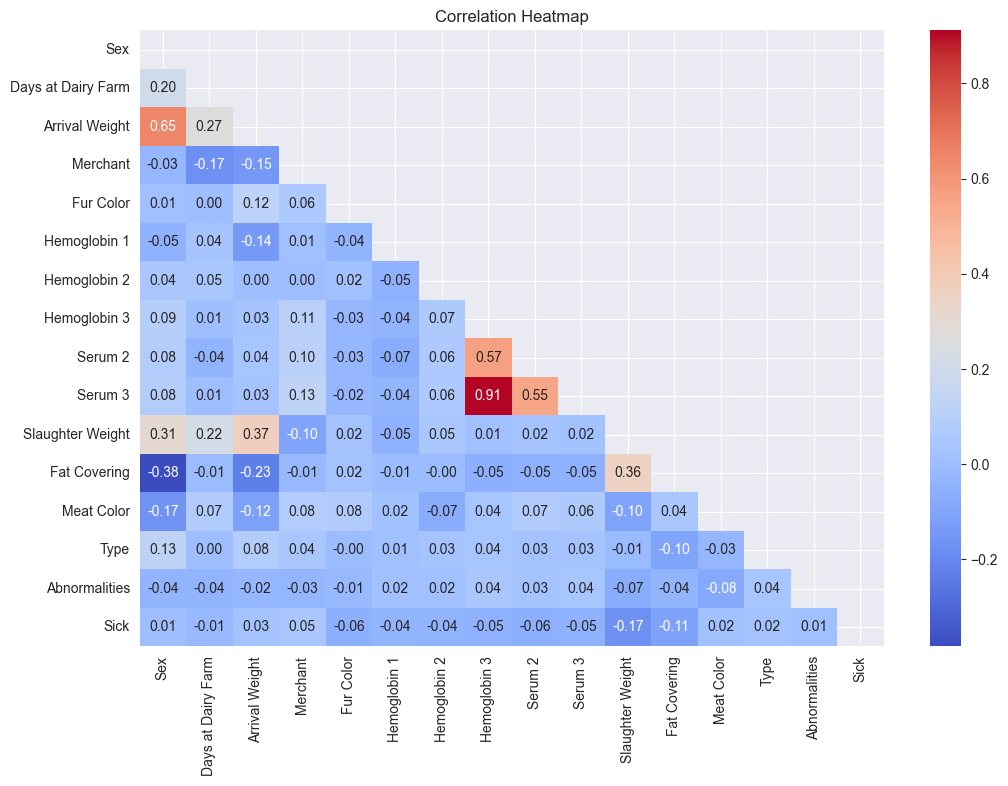

In [533]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2336241

This section covers the data processing and analysis for **Group 2336241** from the `Borne` Farm.

### Group 2336241 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [534]:
df_blood_2336241, df_slh_2336241 = load_group_data(
    borne_farm,
    name_blood='Group 2336241 - blood samples',
    name_slh='Group 2336241 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [535]:
same_cows_2336241 = get_same_cows_ids(df_blood_2336241, df_slh_2336241) 

In [536]:
len(same_cows_2336241)

440

The blood sample data and slaughterhouse data are then combined:

In [537]:
df_combined_2336241 = combine_matching_cows(df_blood_2336241, df_slh_2336241, same_cows_2336241)
print(df_combined_2336241.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [538]:
df_stallijst_2336241 = load_stallijst_data(
    borne_farm, 
    name_stallijst='Group 2336241 Stallijst'
)

df_final_combined_2336241 = combine_stallijst(df_combined_2336241, df_stallijst_2336241)

print(df_final_combined_2336241.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [539]:
df_arrival_weights = load_arrival_weights(
    borne_farm, 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2336241, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [540]:
df_individual_treatments = load_individual_treatments(
    borne_farm, 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [541]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [542]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 33


Matching columns in the dataset are identified:

In [543]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [544]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [545]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'X', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [546]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.227273
HB3                              421            95.681818
S2                                 1             0.227273
S3                               421            95.681818
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      302            68.636364
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [547]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,Slacht datum,Afwijkingen,Calf ID,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Calf ID + Country,Stable,Arrival weight,Sickness Date,Sick
0,4.0,5.2,5.4,0.0,21.0,O0,30,6,172.3,4-8-2023,6-3-2024,1,1272852854,DE,Boerkamp,1,Z,Zwartbont,2023-09-06,33,DE 1272852854,Vd Borne,54.76,NaT,0
1,4.2,6.5,0.0,0.0,0.0,O0,30,6,143.5,8-8-2023,6-3-2024,0,1272867460,DE,Boerkamp,0,Z,Zwartbont,2023-09-06,29,DE 1272867460,Vd Borne,54.76,NaT,0
2,6.5,6.3,0.0,0.0,0.0,O-,20,6,140.5,6-8-2023,8-3-2024,1,1273641162,DE,Boerkamp,1,Z,Zwartbont,2023-09-06,31,DE 1273641162,Vd Borne,54.76,NaT,0
3,4.8,6.5,0.0,0.0,0.0,O-,20,5,135.7,7-8-2023,5-3-2024,1,1406949406,DE,lochimex,1,U,Eenkleurig bruin,2023-09-06,30,DE 1406949406,Vd Borne,49.70,NaT,0
4,4.2,6.6,0.0,0.0,0.0,O+,20,5,137.9,7-8-2023,5-3-2024,0,1505435824,DE,Boerkamp,1,U,Eenkleurig bruin,2023-09-06,30,DE 1505435824,Vd Borne,54.76,NaT,0


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [548]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Country ID + Calf ID', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [549]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date',
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2336241_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2336241_pali.columns)

df_final_cleaned_2336241_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
403,FR 5641400213,FR,5641400213,18-8-2023,1,Vd Borne,19,2023-09-06,43.0,Pali BV BA,Zwartbont,Z,4.0,5.9,0.0,0.0,0.0,NaT,0,7-3-2024,125.4,20,5,O-,1
319,FR 5706492254,FR,5706492254,3-8-2023,1,Vd Borne,34,2023-09-06,43.0,kuipersvee.bv,Zwartbont,Z,6.8,5.4,0.0,0.0,0.0,NaT,0,6-3-2024,186.2,20,5,O0,0
58,FR 4243632484,FR,4243632484,13-8-2023,1,Vd Borne,24,2023-09-06,43.0,kuipersvee.bv,Zwartbont,Z,5.9,4.8,0.0,0.0,0.0,NaT,0,6-3-2024,119.9,10,5,P+,1
140,FR 5945257107,FR,5945257107,10-8-2023,1,Vd Borne,27,2023-09-06,43.0,kuipersvee.bv,Zwartbont,Z,5.3,5.8,0.0,0.0,0.0,NaT,0,7-3-2024,151.6,20,4,O0,0
106,FR 4243571786,FR,4243571786,9-8-2023,1,Vd Borne,28,2023-09-06,43.0,kuipersvee.bv,Zwartbont,Z,5.9,6.2,0.0,0.0,0.0,NaT,0,7-3-2024,138.8,20,5,P+,0


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [550]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    0
2          0     1         0    1
3          1     1         1    1
4          1     2         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

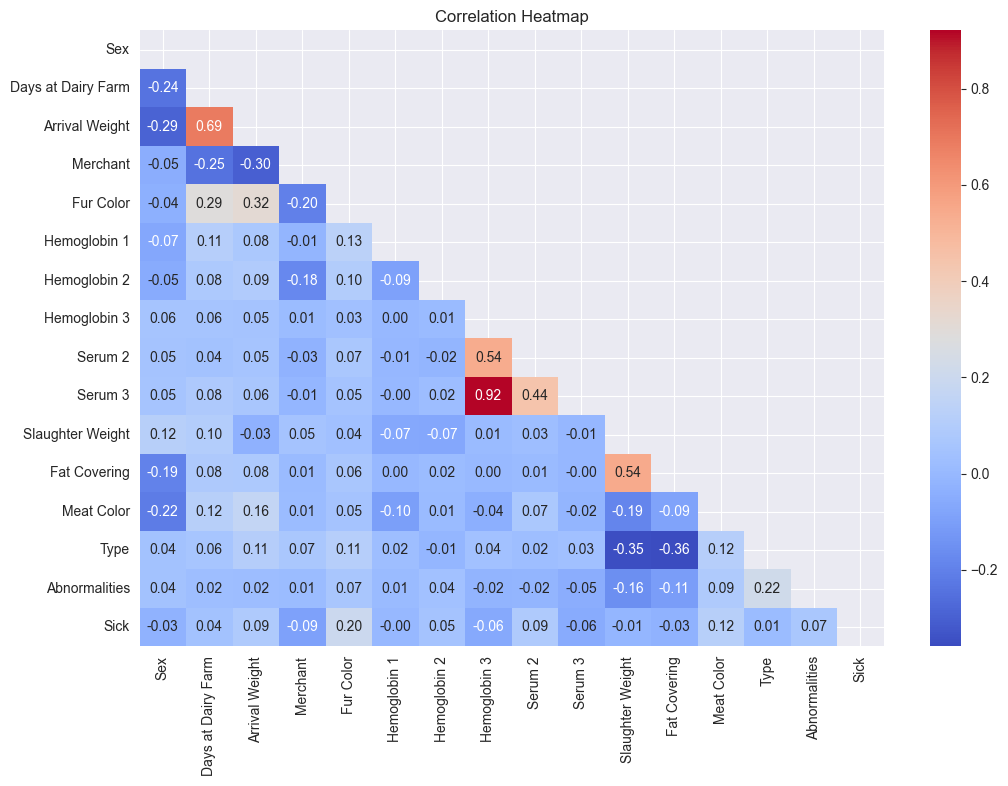

In [551]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2308249

This section covers the data processing and analysis for **Group 2308249** from the `Borne` Farm.

### Group 2308249 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [552]:
df_blood_2308249, df_slh_2308249 = load_group_data(
    borne_farm,
    name_blood='Group 2308249 - blood samples',
    name_slh='Group 2308249 Slaughterhouse',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [553]:
same_cows_2308249 = get_same_cows_ids(df_blood_2308249, df_slh_2308249) 

In [554]:
len(same_cows_2308249)

546

The blood sample data and slaughterhouse data are then combined:

In [555]:
df_combined_2308249 = combine_matching_cows(df_blood_2308249, df_slh_2308249, same_cows_2308249)
print(df_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [556]:
df_stallijst_2308249 = load_stallijst_data(
    borne_farm, 
    name_stallijst='Group 2308249 Stallijst'
)

df_final_combined_2308249 = combine_stallijst(df_combined_2308249, df_stallijst_2308249)

print(df_final_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [557]:
df_arrival_weights = load_arrival_weights(
    borne_farm, 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2308249, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [558]:
df_individual_treatments = load_individual_treatments(
    borne_farm, 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [559]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
       'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [560]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 158


Matching columns in the dataset are identified:

In [561]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [562]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'WerkNr', 'Gewicht',
       'Soort', 'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse',
       'Slacht Datum', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [563]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [564]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                4             0.732601
HB3                              520            95.238095
HB4                              520            95.238095
S2                                 4             0.732601
S3                               520            95.238095
S4                               520            95.238095
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Slacht Datum                       0             0.000000
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant      

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `HB4`, `S2`, `S3`, and `S4`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [565]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['HB4'] = df_final_cleaned['HB4'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)
df_final_cleaned['S4'] = df_final_cleaned['S4'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,HB4,S2,S3,S4,Gewicht,Soort,Kleur,Vet,Geboortedatum,Slacht Datum,Calf ID,Calf ID + Country,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Stable,Arrival weight,Sickness Date,Sick
0,6.4,6.2,0.0,0.0,0.0,0.0,0.0,112.0,13,6,2,2023-01-02 00:00:00,8/23/2023,222680862571,IE 222680862571,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,24,Vd Borne,46.7,2023-03-28,1
1,5.7,5.1,0.0,0.0,0.0,0.0,0.0,128.9,11,6,2,2023-07-02 00:00:00,8/23/2023,214158682440,IE 214158682440,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,18,Vd Borne,46.7,NaT,0
2,6.7,5.6,0.0,0.0,0.0,0.0,0.0,108.2,12,7,2,2023-07-02 00:00:00,8/22/2023,223849832428,IE 223849832428,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,18,Vd Borne,46.7,2023-01-03,1
3,5.2,5.2,0.0,0.0,0.0,0.0,0.0,129.0,11,1,2,2023-07-02 00:00:00,8/22/2023,217152272253,IE 217152272253,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,18,Vd Borne,46.7,2023-01-03,1
4,6.2,6.4,0.0,0.0,0.0,0.0,0.0,90.9,14,6,1,2023-05-02 00:00:00,8/23/2023,219154364201,IE 219154364201,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,20,Vd Borne,46.7,NaT,0


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [566]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'HB4': 'Hemoglobin 4',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'S4': 'Serum 4',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Slacht Datum': 'Slaughter Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Slaughter Weight', 'Type',
       'Meat Color', 'Fat', 'Birth Date', 'Slaughter Date', 'Calf ID',
       'Country ID + Calf ID', 'Country ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at Dairy Farm',
       'Stable', 'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [567]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2308249_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2308249_s.columns)

df_final_cleaned_2308249_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight', 'Fat',
       'Meat Color', 'Type'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat,Meat Color,Type
331,IE 224154053059,IE,224154053059,1/28/2023,1,Vd Borne,23,2023-02-20,50.7,lochimex,Zwartbont,Z,6.3,6.1,0.0,0.0,0.0,NaT,0,8/22/2023,132.9,2,3,11
142,IE 222484682043,IE,222484682043,1/25/2023,1,Vd Borne,31,2023-02-25,46.7,Van Beek Kalvermesterij,Zwartbont,Z,7.0,6.2,0.0,0.0,0.0,2023-05-05,1,8/23/2023,128.7,2,5,10
231,IE 219542380950,IE,219542380950,2023-04-02 00:00:00,1,Vd Borne,16,2023-02-20,46.0,Cor van Dijk veehandel,Zwartbont,Z,4.9,6.3,0.0,0.0,0.0,2023-10-03,1,8/22/2023,136.5,1,4,11
76,IE 217386583582,IE,217386583582,1/30/2023,1,Vd Borne,26,2023-02-25,46.7,Van Beek Kalvermesterij,Zwartbont,Z,4.5,5.6,0.0,0.0,0.0,NaT,0,8/23/2023,146.4,2,4,10
66,IE 218377835132,IE,218377835132,2023-03-02 00:00:00,1,Vd Borne,22,2023-02-25,46.7,Van Beek Kalvermesterij,Zwartbont,Z,5.3,5.6,0.0,0.0,0.0,NaT,0,8/23/2023,160.8,3,4,10


In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [568]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Merchant', 'Sex']].head(5))

   Fur Color  Merchant  Sex
0          0         0    1
1          0         0    1
2          0         0    1
3          0         0    1
4          0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

Number of 1's (female): 546
Number of 0's (male): 0


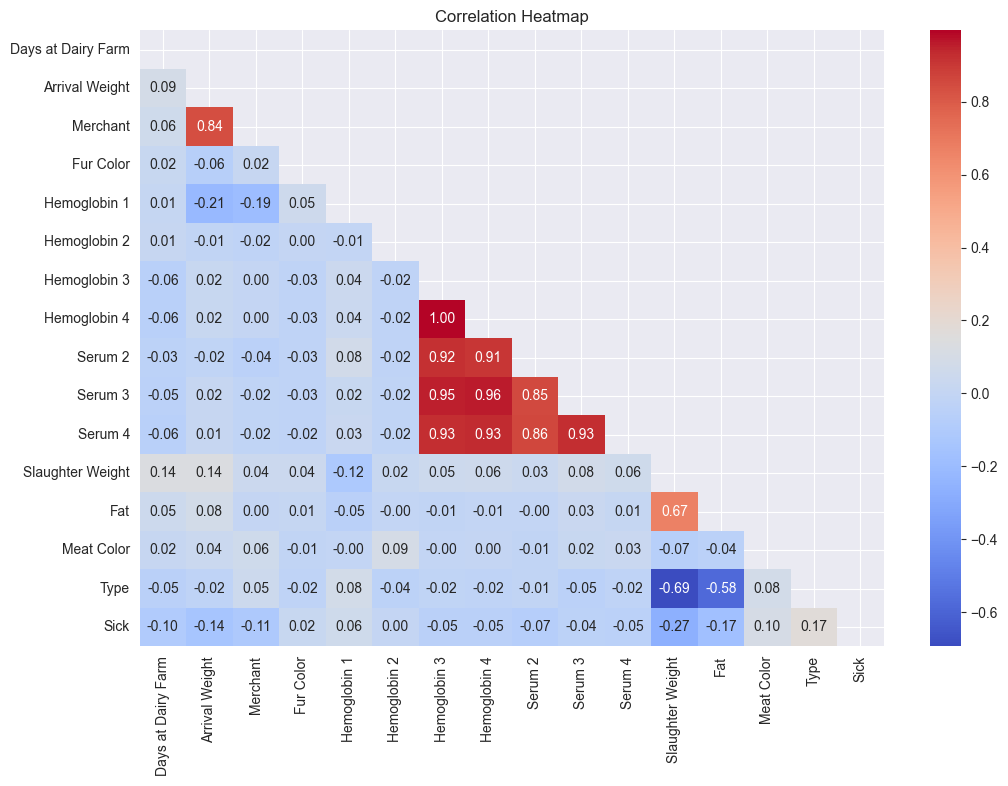

In [569]:
numeric_df = df_final_cleaned[['Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4', 'Serum 2', 
                               'Serum 3', 'Serum 4', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

sex_counts = df_final_cleaned['Sex'].value_counts()
print(f"Number of 1's (female): {sex_counts.get(1, 0)}")
print(f"Number of 0's (male): {sex_counts.get(0, 0)}")

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2308249 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [570]:
df_blood_2308249, df_slh_2308249P = load_group_data(
    borne_farm,
    name_blood='Group 2308249 - blood samples',
    name_slh='Group 2308249 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [571]:
same_cows_2308249P = get_same_cows_ids(df_blood_2308249, df_slh_2308249P) 

In [572]:
len(same_cows_2308249P)

626

The blood sample data and slaughterhouse data are then combined:

In [573]:
df_combined_2308249 = combine_matching_cows(df_blood_2308249, df_slh_2308249P, same_cows_2308249P)
print(df_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [574]:
df_stallijst_2308249 = load_stallijst_data(
    borne_farm, 
    name_stallijst='Group 2308249 Stallijst'
)

df_final_combined_2308249 = combine_stallijst(df_combined_2308249, df_stallijst_2308249)

print(df_final_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [575]:
df_arrival_weights = load_arrival_weights(
    borne_farm, 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2308249, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [576]:
df_individual_treatments = load_individual_treatments(
    borne_farm, 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [577]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
       'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking',
       'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum',
       'Slacht datum', 'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [578]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 123


Matching columns in the dataset are identified:

In [579]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [580]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Volgnr.', 'Koppel',
       'Type', 'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [581]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Type', 'Vetbedekking',
       'Kleur', 'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen',
       'Calf ID', 'Calf ID + Country', 'County ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Arrival weight', 'Sickness Date',
       'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [582]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               12             1.916933
HB3                              597            95.367412
HB4                              598            95.527157
S2                                12             1.916933
S3                               597            95.367412
S4                               598            95.527157
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      517            82.587859
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID     

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `HB4`, `S2`, `S3`, and `S4`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [583]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['HB4'] = df_final_cleaned['HB4'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)
df_final_cleaned['S4'] = df_final_cleaned['S4'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,HB4,S2,S3,S4,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,Slacht datum,Afwijkingen,Calf ID,Calf ID + Country,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Stable,Arrival weight,Sickness Date,Sick
0,6.3,6.0,0.0,0.0,0.0,0.0,0.0,O0,20,4,123.0,5-2-2023,24-8-2023,0,217760131203,IE 217760131203,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,20,Vd Borne,46.7,NaT,0
1,5.9,4.7,0.0,0.0,0.0,0.0,0.0,O0,20,4,120.0,8-2-2023,24-8-2023,1,222187992727,IE 222187992727,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,17,Vd Borne,46.7,NaT,0
2,4.3,5.2,0.0,0.0,0.0,0.0,0.0,O0,20,4,128.5,7-2-2023,24-8-2023,0,224114582723,IE 224114582723,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,18,Vd Borne,46.7,NaT,0
3,6.0,5.5,0.0,0.0,0.0,0.0,0.0,O-,20,5,107.9,1-2-2023,24-8-2023,0,215791893047,IE 215791893047,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,24,Vd Borne,46.7,2023-03-25,1
4,5.9,6.3,0.0,0.0,0.0,0.0,0.0,O0,30,5,142.4,4-2-2023,24-8-2023,0,224974482092,IE 224974482092,IE,Van Beek Kalvermesterij,1,Z,Zwartbont,2023-02-25,21,Vd Borne,46.7,NaT,0


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [584]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'HB4': 'Hemoglobin 4',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'S4': 'Serum 4',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Type', 'Fat Covering', 'Meat Color',
       'Slaughter Weight', 'Birth Date', 'Slaughter Date', 'Abnormalities',
       'Calf ID', 'Country ID + Calf ID', 'Country ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Stable', 'Arrival Weight', 'Sickness Date',
       'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [585]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3',
    'Hemoglobin 4', 
    'Serum 2', 
    'Serum 3',
    'Serum 4',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2308249_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2308249_pali.columns)

df_final_cleaned_2308249_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Sickness Date', 'Sick',
       'Slaughter Date', 'Slaughter Weight', 'Fat Covering', 'Meat Color',
       'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Hemoglobin 4,Serum 2,Serum 3,Serum 4,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
461,IE 214610495595,IE,214610495595,8-2-2023,1,Vd Borne,19,2023-02-27,46.4,Gebr. Fuite BV,Zwartbont,Z,4.6,5.3,0.0,0.0,0.0,0.0,0.0,NaT,0,24-8-2023,109.0,20,9,O0,0
276,IE 216523594508,IE,216523594508,11-2-2023,1,Vd Borne,21,2023-03-04,46.5,lochimex,Zwartbont,Z,5.8,5.5,0.0,0.0,0.0,0.0,0.0,NaT,0,25-8-2023,133.5,30,5,O0,0
149,IE 225951650560,IE,225951650560,31-1-2023,1,Vd Borne,20,2023-02-20,46.0,Cor van Dijk veehandel,Zwartbont,Z,7.3,5.7,0.0,0.0,0.0,0.0,0.0,NaT,0,22-8-2023,123.3,20,5,O0,0
101,IE 225668820498,IE,225668820498,5-2-2023,1,Vd Borne,20,2023-02-25,46.7,Van Beek Kalvermesterij,Zwartbont,Z,6.5,6.7,0.0,0.0,0.0,0.0,0.0,2023-02-25,1,22-8-2023,125.4,20,7,O-,0
202,IE 217693792830,IE,217693792830,2-2-2023,1,Vd Borne,18,2023-02-20,46.0,Cor van Dijk veehandel,Zwartbont,Z,6.0,7.8,0.0,0.0,0.0,0.0,0.0,NaT,0,22-8-2023,117.0,20,6,O0,0


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [586]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    1
2          0     0         0    1
3          0     1         0    1
4          0     0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

Number of 1's (female): 626
Number of 0's (male): 0


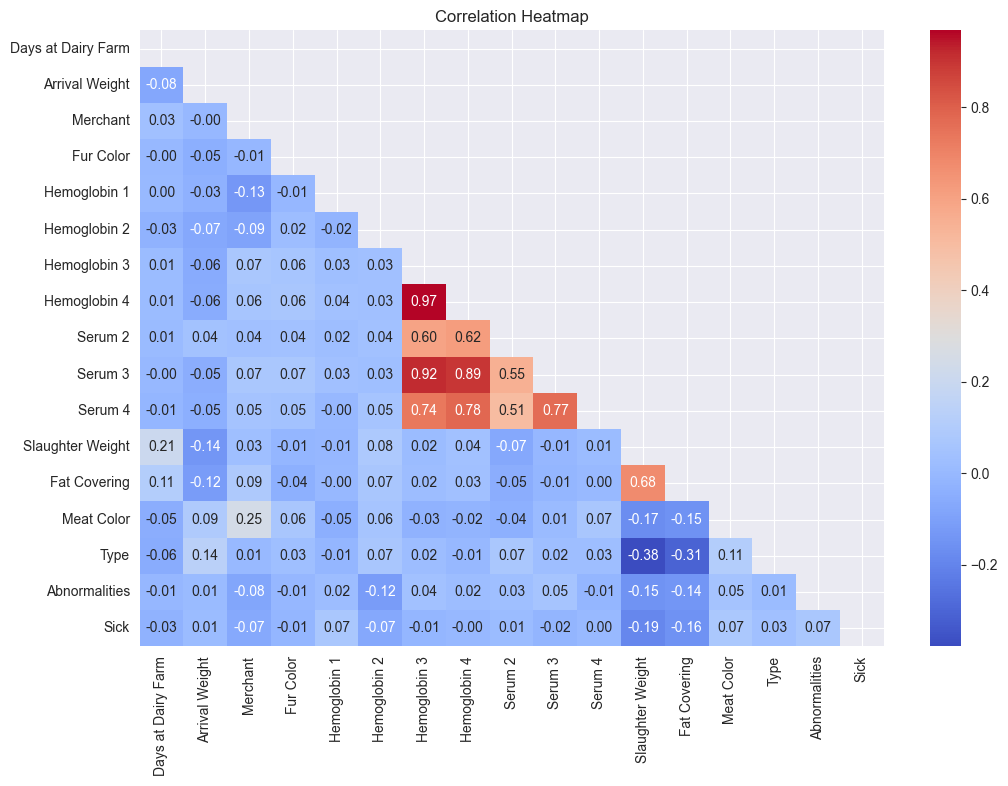

In [587]:
numeric_df = df_final_cleaned[['Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4', 'Serum 2', 
                               'Serum 3', 'Serum 4', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

sex_counts = df_final_cleaned['Sex'].value_counts()
print(f"Number of 1's (female): {sex_counts.get(1, 0)}")
print(f"Number of 0's (male): {sex_counts.get(0, 0)}")

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2229248

This section covers the data processing and analysis for **Group 2229248** from the `Borne` Farm.

### Group 2229248 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [588]:
df_blood_2229248, df_slh_2229248 = load_group_data(
    borne_farm,
    name_blood='Group 2229248 - blood samples',
    name_slh='Group 2229248 Slaughterhouse',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [589]:
same_cows_2229248 = get_same_cows_ids(df_blood_2229248, df_slh_2229248) 

In [590]:
len(same_cows_2229248)

303

The blood sample data and slaughterhouse data are then combined:

In [591]:
df_combined_2229248 = combine_matching_cows(df_blood_2229248, df_slh_2229248, same_cows_2229248)
print(df_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [592]:
df_stallijst_2229248 = load_stallijst_data(
    borne_farm, 
    name_stallijst='Group 2229248 Stallijst'
)

df_final_combined_2229248 = combine_stallijst(df_combined_2229248, df_stallijst_2229248)

print(df_final_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [593]:
df_arrival_weights = load_arrival_weights(
    borne_farm, 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2229248, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [594]:
df_individual_treatments = load_individual_treatments(
    borne_farm, 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [595]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [596]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 93


Matching columns in the dataset are identified:

In [597]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [598]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'WerkNr', 'Gewicht', 'Soort', 'Kleur',
       'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum',
       'Calf ID', 'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [599]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Slacht Datum', 'Calf ID', 'Calf ID + Country',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [600]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                2             0.660066
HB3                              280            92.409241
S2                                 2             0.660066
S3                               280            92.409241
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Slacht Datum                       0             0.000000
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [601]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Gewicht,Soort,Kleur,Vet,Geboortedatum,Slacht Datum,Calf ID,Calf ID + Country,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Stable,Arrival weight,Sickness Date,Sick
0,5.4,6.8,0.0,0.0,0.0,129.6,12,5,2,7/13/2022,2023-06-02,1406655252,DE 1406655252,DE,lochimex,1,Z,Zwartbont,2022-08-03,21,Vd Borne,41.0,NaT,0
1,7.1,7.2,0.0,0.0,0.0,133.5,12,5,2,7/16/2022,2023-06-02,1406681809,DE 1406681809,DE,lochimex,1,Z,Zwartbont,2022-08-03,18,Vd Borne,41.0,NaT,0
2,6.3,5.9,0.0,0.0,0.0,147.2,11,4,3,7/17/2022,2023-06-02,1406572274,DE 1406572274,DE,lochimex,1,U,Eenkleurig bruin,2022-08-03,17,Vd Borne,41.0,NaT,0
3,6.5,6.1,0.0,0.0,0.0,173.5,11,4,3,7/16/2022,2023-06-02,1406701934,DE 1406701934,DE,lochimex,1,Z,Zwartbont,2022-08-03,18,Vd Borne,41.0,NaT,0
4,6.5,6.1,0.0,0.0,0.0,162.3,12,4,3,2022-08-07 00:00:00,2023-06-02,1406572597,DE 1406572597,DE,lochimex,1,Z,Zwartbont,2022-08-03,26,Vd Borne,41.0,NaT,0


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [602]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Slacht Datum': 'Slaughter Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Slaughter Weight', 'Type', 'Meat Color', 'Fat', 'Birth Date',
       'Slaughter Date', 'Calf ID', 'Country ID + Calf ID', 'Country ID',
       'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [603]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2229248_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2229248_s.columns)

df_final_cleaned_2229248_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight', 'Fat',
       'Meat Color', 'Type'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat,Meat Color,Type
71,DE 1604573071,DE,1604573071,6/29/2022,0,Vd Borne,28,2022-07-27,42.0,lochimex,Eenkleurig bruin,U,6.4,5.5,0.0,0.0,0.0,NaT,0,2023-06-02,133.10,3,6,12
54,DE 1406541148,DE,1406541148,2022-09-07 00:00:00,1,Vd Borne,18,2022-07-27,42.0,lochimex,Zwartbont,Z,7.2,6.3,0.0,0.0,0.0,NaT,0,2023-06-02,108.50,2,5,13
80,DE 1269773951,DE,1269773951,2022-08-07 00:00:00,1,Vd Borne,19,2022-07-27,42.0,lochimex,Eenkleurig bruin,U,5.6,6.1,0.0,0.0,0.0,NaT,0,2023-08-02,161.60,2,6,10
297,DE 1406779086,DE,1406779086,2022-09-07 00:00:00,1,Vd Borne,18,2022-07-27,42.0,lochimex,Zwartbont,Z,6.9,6.4,0.0,0.0,0.0,2022-08-29,1,2023-08-02,117.70,2,9,12
245,DE 1406622172,DE,1406622172,7/14/2022,1,Vd Borne,20,2022-08-03,41.0,lochimex,Zwartbont,Z,6.2,6.1,0.0,97.0,0.0,2022-10-15,1,2023-07-02,126.24,2,6,11


In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [604]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Merchant', 'Sex']].head(5))

   Fur Color  Merchant  Sex
0          0         0    1
1          0         0    1
2          1         0    1
3          0         0    1
4          0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

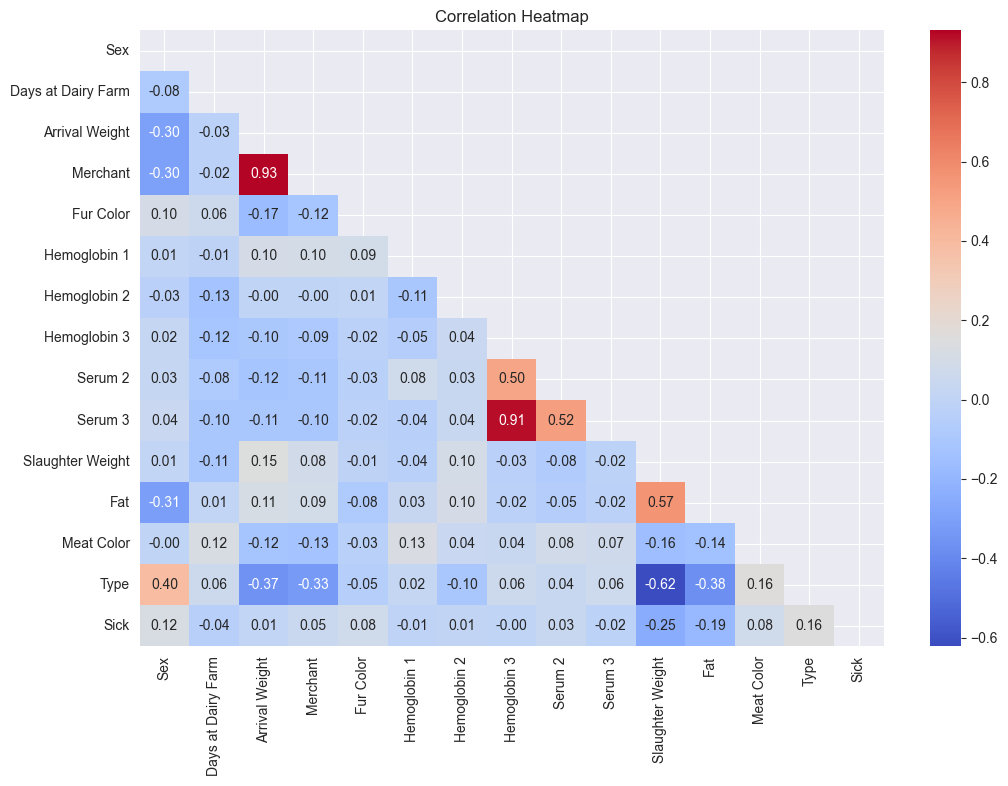

In [605]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2229248 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [606]:
df_blood_2229248, df_slh_2229248P = load_group_data(
    borne_farm,
    name_blood='Group 2229248 - blood samples',
    name_slh='Group 2229248 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [607]:
same_cows_2229248P = get_same_cows_ids(df_blood_2229248, df_slh_2229248P) 

In [608]:
len(same_cows_2229248P)

120

The blood sample data and slaughterhouse data are then combined:

In [609]:
df_combined_2229248 = combine_matching_cows(df_blood_2229248, df_slh_2229248P, same_cows_2229248P)
print(df_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [610]:
df_stallijst_2229248 = load_stallijst_data(
    borne_farm, 
    name_stallijst='Group 2229248 Stallijst'
)

df_final_combined_2229248 = combine_stallijst(df_combined_2229248, df_stallijst_2229248)

print(df_final_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [611]:
df_arrival_weights = load_arrival_weights(
    borne_farm, 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2229248, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [612]:
df_individual_treatments = load_individual_treatments(
    borne_farm, 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [613]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [614]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 47


Matching columns in the dataset are identified:

In [615]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [616]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [617]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [618]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.840336
HB3                              116            97.478992
S2                                 1             0.840336
S3                               116            97.478992
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                       84            70.588235
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex           

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [619]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,Slacht datum,Afwijkingen,Calf ID,Calf ID + Country,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Stable,Arrival weight,Sickness Date,Sick
0,6.0,5.2,0.0,0.0,0.0,O-,20,5,124.3,14-7-2022,6-2-2023,0,1406570666,DE 1406570666,DE,Pali BV BA,0,Z,Zwartbont,2022-08-03,20,Vd Borne,43.0,2022-08-29,1
1,7.3,5.7,0.0,0.0,0.0,O-,30,6,128.5,17-7-2022,6-2-2023,1,1406686947,DE 1406686947,DE,Pali BV BA,0,Z,Zwartbont,2022-08-03,17,Vd Borne,43.0,NaT,0
2,6.2,5.3,0.0,0.0,0.0,P0,20,5,122.8,5-7-2022,6-2-2023,1,1406570654,DE 1406570654,DE,Pali BV BA,0,Z,Zwartbont,2022-08-03,29,Vd Borne,43.0,NaT,0
3,5.7,6.4,0.0,0.0,0.0,O+,30,6,160.6,17-7-2022,6-2-2023,0,1604557390,DE 1604557390,DE,Pali BV BA,1,Z,Zwartbont,2022-08-03,17,Vd Borne,43.0,2022-08-30,1
4,5.4,5.3,0.0,0.0,0.0,O-,20,5,124.2,14-7-2022,6-2-2023,0,1406570665,DE 1406570665,DE,Pali BV BA,0,Z,Zwartbont,2022-08-03,20,Vd Borne,43.0,2022-10-15,1


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [620]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID + Calf ID',
       'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [621]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2229248_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2229248_pali.columns)

df_final_cleaned_2229248_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
78,DE 1604552728,DE,1604552728,13-7-2022,1,Vd Borne,21,2022-08-03,41.0,lochimex,Zwartbont,Z,5.6,6.0,0.0,0.0,0.0,NaT,0,6-2-2023,152.3,30,6,O0,1
11,DE 1269773938,DE,1269773938,30-6-2022,1,Vd Borne,27,2022-07-27,42.0,lochimex,Zwartbont,Z,5.9,6.0,0.0,0.0,0.0,2022-09-21,1,3-2-2023,143.7,20,6,O-,1
25,DE 1406681812,DE,1406681812,18-7-2022,1,Vd Borne,16,2022-08-03,41.0,lochimex,Zwartbont,Z,6.6,7.4,0.0,0.0,0.0,2022-06-09,1,6-2-2023,113.1,10,6,P0,0
81,DE 1505135612,DE,1505135612,11-7-2022,1,Vd Borne,23,2022-08-03,41.0,lochimex,Zwartbont,Z,6.0,5.8,0.0,0.0,0.0,2022-05-09,1,6-2-2023,142.3,20,5,P+,0
85,DE 1604496151,DE,1604496151,16-7-2022,1,Vd Borne,18,2022-08-03,41.0,lochimex,Zwartbont,Z,5.4,6.8,0.0,0.0,0.0,NaT,0,6-2-2023,180.7,30,7,O0,0


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [622]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    0
1          0     0         0    0
2          0     1         0    0
3          0     2         0    1
4          0     0         0    0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

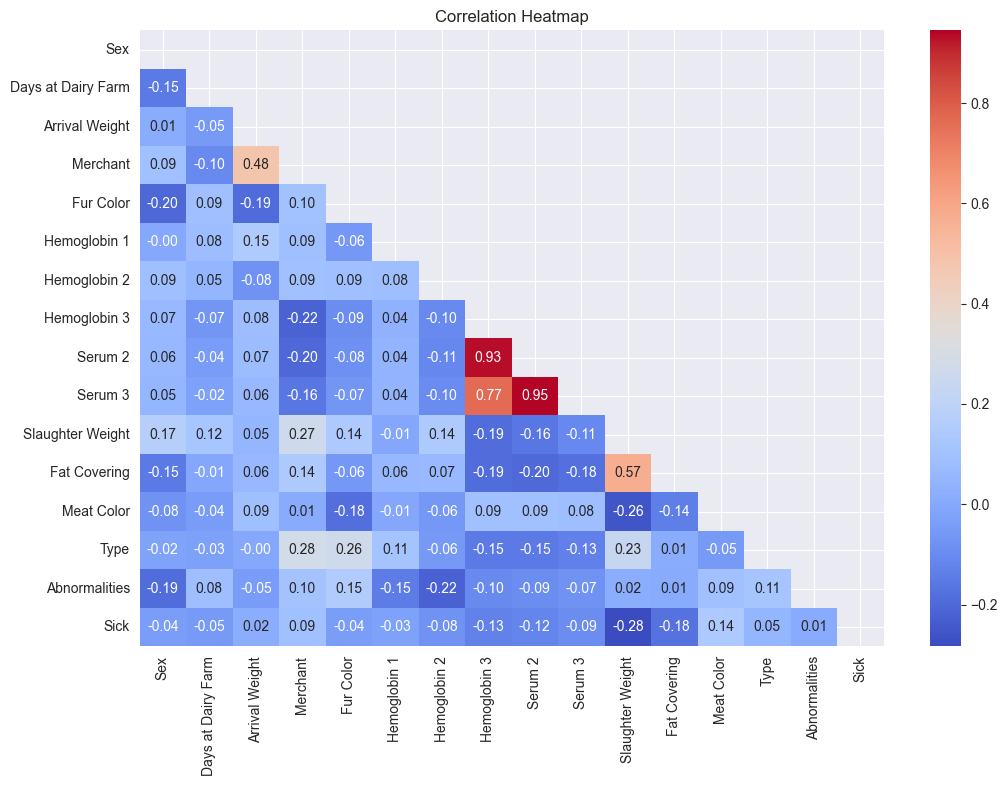

In [623]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2151247

This section covers the data processing and analysis for **Group 2151247** from the `Borne` Farm.

### Group 2151247 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [624]:
df_blood_2151247, df_slh_2151247 = load_group_data(
    borne_farm,
    name_blood='Group 2151247 - blood samples',
    name_slh='Group 2151247 Slaughterhouse',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [625]:
same_cows_2151247 = get_same_cows_ids(df_blood_2151247, df_slh_2151247) 

In [626]:
len(same_cows_2151247)

518

The blood sample data and slaughterhouse data are then combined:

In [627]:
df_combined_2151247 = combine_matching_cows(df_blood_2151247, df_slh_2151247, same_cows_2151247)
print(df_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [628]:
df_stallijst_2151247 = load_stallijst_data(
    borne_farm, 
    name_stallijst='Group 2151247 Stallijst'
)

df_final_combined_2151247 = combine_stallijst(df_combined_2151247, df_stallijst_2151247)

print(df_final_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [629]:
df_arrival_weights = load_arrival_weights(
    borne_farm, 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2151247, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [630]:
df_individual_treatments = load_individual_treatments(
    borne_farm, 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [631]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [632]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 184


Matching columns in the dataset are identified:

In [633]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [634]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'WerkNr', 'Gewicht', 'Soort', 'Kleur',
       'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Calf ID', 'X',
       'County ID', 'Birth Date', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Calf ID + Country', 'Stable', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [635]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'X', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Calf ID', 'County ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [636]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               11             2.123552
HB3                              495            95.559846
S2                                11             2.123552
S3                               495            95.559846
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter                       0             0.000000
Fur Color                          0             0.000000
Arrival Date a

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [637]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Gewicht,Soort,Kleur,Vet,Geboortedatum,Calf ID,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Calf ID + Country,Stable,Arrival weight,Sickness Date,Sick
0,6.3,5.1,0.0,0.0,0.0,123.2,12,5,2,2021-06-12 00:00:00,892646108,NL,"sloot, bert",0,ZB,Zwartbont,2021-12-23,17,NL 892646108,Vd Borne,44.0,NaT,0
1,6.3,5.7,0.0,0.0,0.0,118.6,13,5,2,2021-10-12 00:00:00,578626691,NL,"sloot, bert",1,ZB,Zwartbont,2021-12-23,13,NL 578626691,Vd Borne,44.0,NaT,0
2,5.5,5.9,0.0,0.0,0.0,155.2,12,6,2,2021-07-12 00:00:00,609609778,NL,"sloot, bert",1,ZB,Zwartbont,2021-12-23,16,NL 609609778,Vd Borne,44.0,NaT,0
3,6.3,6.1,0.0,0.0,0.0,146.8,13,6,2,2021-09-12 00:00:00,567928315,NL,"sloot, bert",1,ZB,Zwartbont,2021-12-23,14,NL 567928315,Vd Borne,44.0,NaT,0
4,5.5,7.8,0.0,0.0,0.0,142.5,12,10,2,2021-09-12 00:00:00,573265196,NL,"sloot, bert",1,ZB,Zwartbont,2021-12-23,14,NL 573265196,Vd Borne,44.0,NaT,0


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [638]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Slaughter Weight', 'Type', 'Meat Color', 'Fat', 'Birth Date',
       'Calf ID', 'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm',
       'Country ID + Calf ID', 'Stable', 'Arrival Weight', 'Sickness Date',
       'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [639]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2151247_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2151247_s.columns)

df_final_cleaned_2151247_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Weight', 'Fat', 'Meat Color',
       'Type'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Weight,Fat,Meat Color,Type
305,DE 1306524980,DE,1306524980,2021-02-12 00:00:00,0,Vd Borne,19,2021-12-21,47.5,Gebr. Fuite BV,Eenkleurig bruin,EB,4.6,5.3,0.0,0.0,0.0,NaT,0,159.00,4,5,10
28,NL 615382119,NL,615382119,2021-08-12 00:00:00,1,Vd Borne,15,2021-12-23,44.0,"sloot, bert",Zwartbont,ZB,5.8,5.7,0.0,0.0,0.0,2022-02-22,1,94.50,1,5,15
284,LU 818157853,LU,818157853,11/27/2021,1,Vd Borne,18,2021-12-15,47.5,Gebr. Fuite BV,Zwartbont,ZB,5.3,5.3,0.0,0.0,0.0,NaT,0,165.30,3,5,11
214,DE 1505096007,DE,1505096007,11/24/2021,1,Vd Borne,21,2021-12-15,42.0,lochimex,Zwartbont,ZB,6.8,6.0,0.0,0.0,0.0,2022-02-18,1,151.00,3,5,11
201,NL 633131414,NL,633131414,11/29/2021,1,Vd Borne,24,2021-12-23,44.0,"sloot, bert",Roodbont,RB,5.0,6.0,0.0,0.0,0.0,NaT,0,138.59,3,8,12


In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [640]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0    12         0    0
1          0    13         0    1
2          0    12         0    1
3          0    13         0    1
4          0    12         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

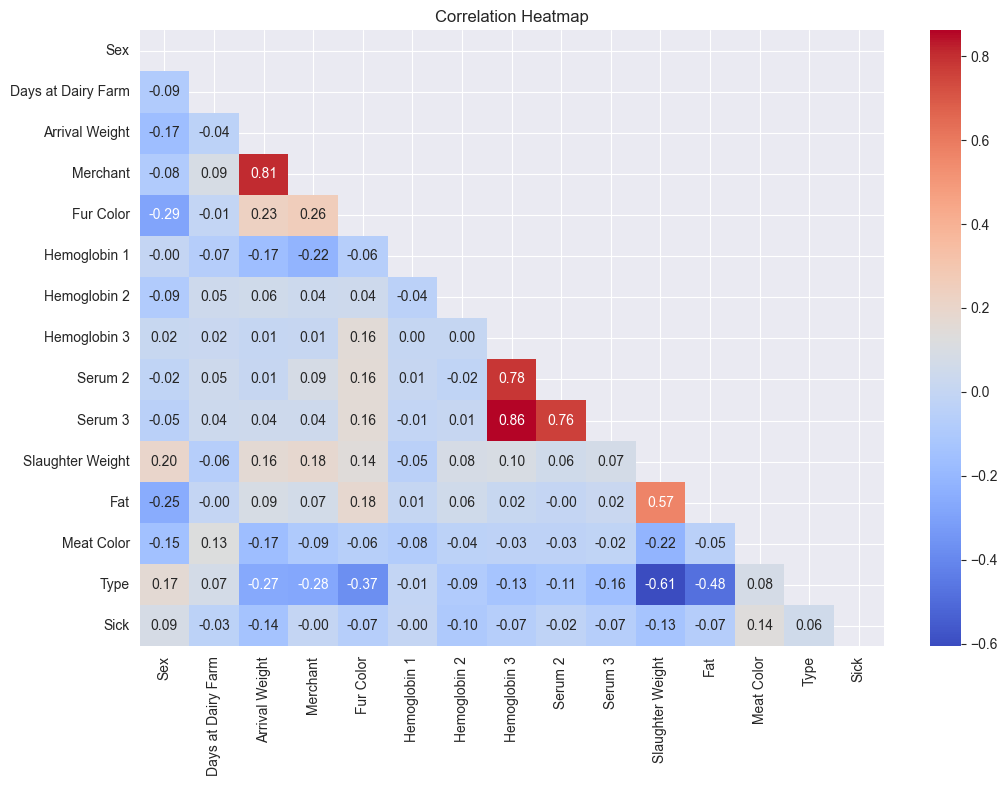

In [641]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2151247 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [642]:
df_blood_2151247, df_slh_2151247P = load_group_data(
    borne_farm,
    name_blood='Group 2151247 - blood samples',
    name_slh='Group 2151247 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [643]:
same_cows_2151247P = get_same_cows_ids(df_blood_2151247, df_slh_2151247P) 

In [644]:
len(same_cows_2151247P)

145

The blood sample data and slaughterhouse data are then combined:

In [645]:
df_combined_2151247 = combine_matching_cows(df_blood_2151247, df_slh_2151247P, same_cows_2151247P)
print(df_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [646]:
df_stallijst_2151247 = load_stallijst_data(
    borne_farm, 
    name_stallijst='Group 2151247 Stallijst'
)

df_final_combined_2151247 = combine_stallijst(df_combined_2151247, df_stallijst_2151247)

print(df_final_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [647]:
df_arrival_weights = load_arrival_weights(
    borne_farm, 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2151247, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [648]:
df_individual_treatments = load_individual_treatments(
    borne_farm, 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [649]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [650]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 45


Matching columns in the dataset are identified:

In [651]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [652]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [653]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'X', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [654]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.689655
HB3                              141            97.241379
S2                                 1             0.689655
S3                               141            97.241379
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      109            75.172414
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [655]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

,HB1,HB2,HB3,S2,S3,Type,Vetbedekking,Kleur,Gewicht,Geboorte datum,Slacht datum,Afwijkingen,Calf ID,County ID,Merchant,Sex,Color Letter,Fur Color,Arrival Date at Veal Farm,Days at diary farm,Calf ID + Country,Stable,Arrival weight,Sickness Date,Sick
0,5.3,6.5,0.0,0.0,0.0,O-,20,5,157.1,29-11-2021,1-7-2022,0,1406595212,DE,lochimex,1,ZB,Zwartbont,2021-12-15,16,DE 1406595212,Vd Borne,42.0,NaT,0
1,5.5,6.3,0.0,0.0,0.0,O-,20,5,140.1,27-11-2021,1-7-2022,0,1604424000,DE,lochimex,1,ZB,Zwartbont,2021-12-15,18,DE 1604424000,Vd Borne,42.0,NaT,0
2,6.0,5.8,0.0,0.0,0.0,O-,20,6,146.7,27-11-2021,1-7-2022,0,1406533395,DE,lochimex,1,ZB,Zwartbont,2021-12-15,18,DE 1406533395,Vd Borne,42.0,2022-08-02,1
3,6.0,5.1,0.0,0.0,0.0,O-,20,6,142.5,28-11-2021,1-7-2022,0,1406534595,DE,lochimex,1,ZB,Zwartbont,2021-12-15,17,DE 1406534595,Vd Borne,42.0,NaT,0
4,5.7,5.6,0.0,0.0,0.0,O-,20,5,144.9,1-12-2021,1-7-2022,0,681201068,NL,"sloot, bert",1,RB,Roodbont,2021-12-23,22,NL 681201068,Vd Borne,44.0,NaT,0


This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [656]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Country ID + Calf ID', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [657]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2151247_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2151247_pali.columns)

df_final_cleaned_2151247_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


,Country ID + Calf ID,Country ID,Calf ID,Birth Date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur Color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sickness Date,Sick,Slaughter Date,Slaughter Weight,Fat Covering,Meat Color,Type,Abnormalities
52,DE 1406432861,DE,1406432861,4-12-2021,1,Vd Borne,18,2021-12-22,44.0,lochimex,Zwartbont,ZB,5.4,6.5,0.0,0.0,0.0,NaT,0,29-6-2022,149.6,20,9,O0,0
56,DE 1406468504,DE,1406468504,28-11-2021,1,Vd Borne,24,2021-12-22,44.0,lochimex,Eenkleurig bruin,EB,4.9,6.5,0.0,0.0,0.0,NaT,0,29-6-2022,156.0,30,7,O0,1
117,DE 1406534593,DE,1406534593,25-11-2021,1,Vd Borne,20,2021-12-15,42.0,lochimex,Zwartbont,ZB,4.9,5.4,0.0,0.0,0.0,NaT,0,30-6-2022,141.8,20,6,O-,0
119,DE 1604458412,DE,1604458412,22-11-2021,1,Vd Borne,23,2021-12-15,42.0,lochimex,Zwartbont,ZB,7.0,5.5,0.0,0.0,0.0,NaT,0,30-6-2022,92.0,10,4,P0,0
44,DE 1406626059,DE,1406626059,7-12-2021,1,Vd Borne,15,2021-12-22,44.0,lochimex,Eenkleurig bruin,EB,6.0,7.0,0.0,0.0,0.0,NaT,0,30-6-2022,129.0,20,10,O0,0


In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [658]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    1
2          0     0         0    1
3          0     0         0    1
4          1     0         1    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

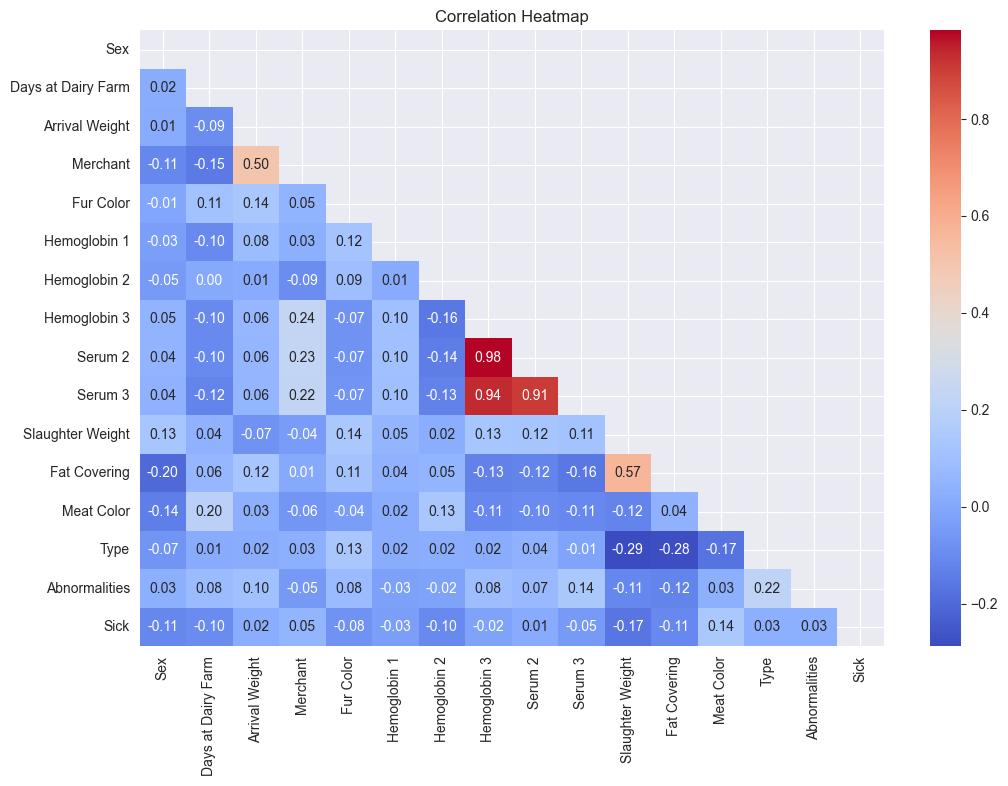

In [659]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Combined Data (Borne farm)

### Data SlaughterhouseS

The three previously cleaned and analysed dataframes (from Group 2308249 S, Group 2229248 S & Group 2151247 S) are merged into a single dataframe. This allows for a consolidated analysis of all (SlaughterhouseS) calf records.

Additionally, the total number of rows (calves) in the merged dataset is printed for reference, along with a count of sick calves, providing an initial overview of the data’s size and distribution.

In [660]:
borne_df_s = pd.concat([
    df_final_cleaned_2308249_s,
    df_final_cleaned_2229248_s
], ignore_index=True)

print(len(borne_df_s))

count_sick = borne_df_s['Sick'].sum()
print(f'Count of sick calves: {count_sick}')

849
Count of sick calves: 251


This cell introduces a new feature, `Season`, which categorizes each calf's birth season based on its birth month. The custom function `get_season()` defines the four seasons, and each calf is assigned a season accordingly. This is followed by converting the season labels into numeric values under the `Season_Born` column, facilitating potential model use.

A sample of the `Birth Date`, `Season`, and `Season_Born` columns is displayed to verify the transformation, and the distribution of calves by birth season is printed to assess seasonal data balance.

In [661]:
borne_df_s['Birth Date'] = pd.to_datetime(borne_df_s['Birth Date'], dayfirst=True)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

borne_df_s['Season'] = borne_df_s['Birth Date'].dt.month.apply(get_season)

borne_df_s['Season_Born'] = pd.factorize(borne_df_s['Season'])[0]

print(borne_df_s[['Birth Date', 'Season', 'Season_Born']].head())
season_counts = borne_df_s['Season'].value_counts()
print("Number of calves born in each season:")
print(season_counts)

  Birth Date  Season  Season_Born
0 2023-01-02  Winter            0
1 2023-07-02  Summer            1
2 2023-07-02  Summer            1
3 2023-07-02  Summer            1
4 2023-05-02  Spring            2
Number of calves born in each season:
Season
Winter    422
Summer    223
Spring    125
Autumn     79
Name: count, dtype: int64


This section calculates and presents **missing values (NaNs)** for each column. The output includes both the count and percentage of NaNs relative to the dataset's total size, providing insight into data completeness.

In [662]:
nan_counts = borne_df_s.isna().sum()
total_counts = len(borne_df_s)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
Country ID + Calf ID               0             0.000000
Country ID                         0             0.000000
Calf ID                            0             0.000000
Birth Date                         0             0.000000
Sex                                0             0.000000
Stable                             0             0.000000
Days at Dairy Farm                 0             0.000000
Arrival Date at Veal Farm          0             0.000000
Arrival Weight                     0             0.000000
Merchant                           0             0.000000
Fur Color                          0             0.000000
Color Letter                       0             0.000000
Hemoglobin 1                       0             0.000000
Hemoglobin 2                       0             0.000000
Hemoglobin 3                       0             0.000000
Serum 2                            0             0.000000
Serum 3       

The categorical columns `Fur Color`, `Merchant`, and `Country ID` are transformed into numerical codes to enable their use in correlation analysis and modeling. This factorization assigns unique integer values to each category in these columns. Following the transformation, the code prints the number of unique values in each of these columns to confirm the encoding. Additionally, a sample of the transformed values is displayed to verify that the encoding has been applied correctly.

In [663]:
borne_df_s['Fur Color'] = pd.factorize(borne_df_s['Fur Color'])[0]
borne_df_s['Merchant'] = pd.factorize(borne_df_s['Merchant'])[0]
borne_df_s['Country ID'] = pd.factorize(borne_df_s['Country ID'])[0]

unique_counts = {
    'Fur Color': borne_df_s['Fur Color'].nunique(),
    'Merchant': borne_df_s['Merchant'].nunique(),
    'Country ID': borne_df_s['Country ID'].nunique()
}

print(unique_counts)

print(borne_df_s[['Fur Color', 'Merchant', 'Country ID']].head(5))

{'Fur Color': 4, 'Merchant': 4, 'Country ID': 2}
   Fur Color  Merchant  Country ID
0          0         0           0
1          0         0           0
2          0         0           0
3          0         0           0
4          0         0           0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

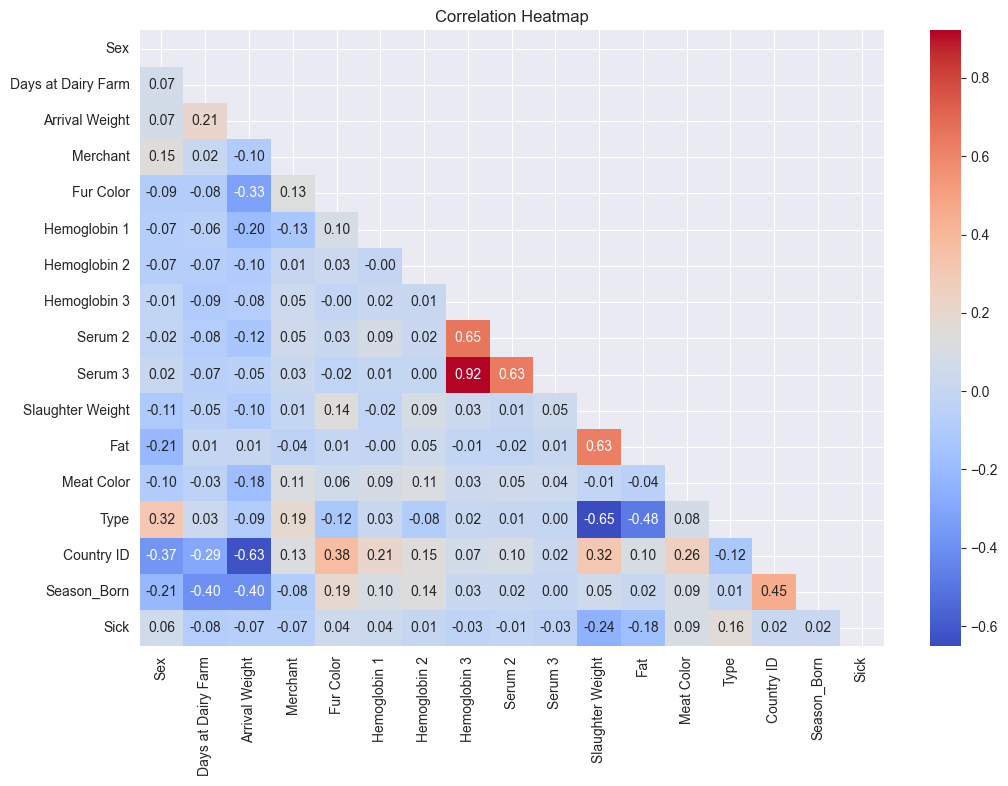

In [664]:
numeric_df = borne_df_s[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                          'Merchant', 'Fur Color', 'Hemoglobin 1', 
                          'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                          'Serum 3', 'Slaughter Weight', 
                          'Fat', 'Meat Color', 'Type', 'Country ID', 'Season_Born', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

#### Support Vector Machine (Regression) - Data SlaughterhouseS

This code cell performs several key steps to prepare the data, train the model, and evaluate its performance on predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the SVR model**  
   A Support Vector Regression (SVR) model is trained on the scaled training data. SVR is traditionally used for continuous target variables, it is explored here to see if it can help in predicting the `Sick` status, albeit as a regression task. 

5. **Model evaluation**  
   The `R^2` score on the test set is calculated to determine the proportion of variance in `Sick` explained by the model. An `R^2` score closer to 1 would indicate a strong model, whereas values near or below zero suggest weak predictive power. This initial score provides insight into the model's suitability for this task.

6. **Error metrics**  
   Two error metrics are computed: 
   - **Root Mean Squared Error (RMSE)**: Measures the average prediction error, with larger errors penalized more heavily.
   - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions, providing a straightforward measure of model accuracy.

7. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.

In [665]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

There are in total 849 observations, of which 679 are now in the train set, and 170 in the test set.
Model R^2: -0.09
Root Mean Squared Error (RMSE): 0.48
Mean Absolute Error (MAE): 0.36
Cross-Validation R^2 scores: [-0.03774525 -0.15131111  0.01619503  0.04141453 -0.09841957]
Mean Cross-Validation R^2: -0.05


**Results:**

- **R^2 score**:  
  The score of -0.02 indicates that the SVR model explains almost none of the variance in the target variable. This low score suggests the model may not be effectively capturing the patterns needed for reliable predictions.
  - Given the limited range of `Sick` (0 to 1), R² may be less informative on its own and should be interpreted alongside error metrics like RMSE and MAE.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.47 and MAE of 0.36 represent substantial prediction errors, especially given the target’s range from 0 to 1. These metrics imply that the model's predictions often deviate significantly from the actual values, reinforcing the limitations in predictive accuracy indicated by the low R^2.
  - In this context, the errors are large relative to the target range, which suggests that the model might not be suitable for this regression task without further tuning or alternative approaches.

- **Cross-validation R^2 scores**:  
  The cross-validation scores, ranging from -0.03 to -0.13 with a mean of -0.07, are consistently negative. This indicates that the model performs poorly across different data folds, which highlights a lack of generalizability and further suggests that SVR may not be the most appropriate model for this prediction task.

In [666]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

     Actual  Predicted
245       0   0.082599
534       0   0.120055
626       0   0.026309
326       0  -0.021640
390       0   0.185272
663       1   0.220139
583       1   0.054669
131       1   0.252096
463       1   0.548495
488       1   0.058560


#### Logistic Regression (Classification) - Data SlaughterhouseS

This code cell prepares the data, trains a class-balanced **Logistic Regression** model, and evaluate its performance in predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. By defining `Sick` as the target, the goal is to predict whether or not an observation is classified as "sick" based on other factors. 

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the logistic regression model**  
   A Logistic Regression model with `class_weight='balanced'` is used to account for class imbalance. This configuration assigns a higher weight to the minority class, potentially improving the model’s ability to correctly predict the "sick" class.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **ROC AUC Score**: The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) score measures the model’s ability to distinguish between the "sick" and "not sick" classes. An AUC score ranges from 0 to 1:
      - **1** indicates perfect discrimination, where the model accurately distinguishes between all "sick" and "not sick" cases.
      - **0.5** suggests no discriminatory power, equivalent to random guessing.
      - **Values closer to 1** indicate stronger model performance in correctly classifying cases, with higher scores representing a better balance between true positive and false positive rates across all possible thresholds.
   - **Confusion matrix**: Shows true positives, true negatives, false positives, and false negatives, providing insight into prediction errors.
   - **Classification report**: Displays precision, recall, and F1-score for both classes, essential for evaluating performance on imbalanced data.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The average cross-validation ROC AUC score serves as an indicator of the model’s consistency.

In [667]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])

print(f"ROC AUC Score: {roc_auc:.2f}")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

There are in total 849 observations, of which 679 are now in the train set, and 170 in the test set.
ROC AUC Score: 0.63
Confusion Matrix:
 [[71 49]
 [18 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.59      0.68       120
           1       0.40      0.64      0.49        50

    accuracy                           0.61       170
   macro avg       0.60      0.62      0.58       170
weighted avg       0.68      0.61      0.62       170

Cross-Validation AUC scores: [0.62682292 0.60364583 0.62161458 0.76816431 0.62842105]
Mean Cross-Validation AUC: 0.65


**Results**

- **ROC AUC score**
    The ROC AUC score of 0.67 indicates moderate discrimination ability.
- **Confusion matrix**
    The confusion matrix shows that the model has higher recall for "sick" cases (class 1), suggesting improved sensitivity to the minority class due to balanced class weighting. However, the model still struggles with misclassifications, with 77 false positives for "not sick" cases.
- **Classification Report**
    - **Class 0 ("not sick")**: Precision of 0.79 and recall of 0.59, indicating that the model has moderate predictive success but also misclassifies several "not sick" cases as "sick."
    - **Class 1 ("sick")**: Precision of 0.43 and recall of 0.66, showing that while the model identifies "sick" cases with reasonable recall, it is not sufficiently specific, given the lower precision.
- **Cross-Validation AUC scores**
    The cross-validation AUC scores vary from 0.53 to 0.70, with a mean AUC of 0.63. This variability suggests that further tuning or an alternative model may be necessary to achieve higher stability and reliability in predicting the "sick" class.

In [668]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

     Actual  Predicted
245       0          1
534       0          0
626       0          1
326       0          0
390       0          0
663       1          1
583       1          0
131       1          0
463       1          1
488       1          0


#### Linear Regression (Regression) - Data SlaughterhouseS

This code cell prepares the data, trains a **Linear Regression** model, and evaluates its performance in predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the linear regression model**  
   A Linear Regression model is fitted on the scaled training data. The goal is to learn the relationship between the features and the target variable.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **R² Score**: Indicates how well the model explains the variance in the target variable. Values closer to 1 suggest better performance.
   - **Root Mean Squared Error (RMSE)**: Measures the average magnitude of the errors between predicted and actual values, providing insight into model accuracy.
   - **Mean Absolute Error (MAE)**: Represents the average absolute difference between predicted and actual values, giving a straightforward measure of prediction error.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.


In [669]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

There are in total 849 observations, of which 679 are now in the train set, and 170 in the test set.
Model R^2: 0.03
Root Mean Squared Error (RMSE): 0.45
Mean Absolute Error (MAE): 0.39
Cross-Validation R^2 scores: [ 0.00062582 -0.00307469 -0.00874788  0.16384589  0.02274224]
Mean Cross-Validation R^2: 0.04


**Results:**

- **R² score**:  
  The R² score of 0.08 indicates that the linear regression model explains only 8% of the variance in the target variable `Sick`. This low score suggests that the model may not be effectively capturing the underlying patterns in the data.
  - Given the limited range of `Sick` (0 to 1), R² may be less informative on its own and should be interpreted alongside error metrics like RMSE and MAE.

- **Error metrics (RMSE and MAE)**:  
  - The **Root Mean Squared Error (RMSE)** of 0.45 and **Mean Absolute Error (MAE)** of 0.40 represent substantial prediction errors, especially considering the target's range from 0 to 1. These values indicate that the model's predictions frequently deviate significantly from the actual values, reinforcing the limitations suggested by the low R² score.
  - Given the target range, these errors are relatively large, suggesting that this linear regression model may not be suitable for the prediction task without further tuning or alternative modeling approaches.

- **Cross-validation R² scores**:  
  The cross-validation R² scores range from -0.05 to 0.11 with a mean of 0.03, which highlights that the model performs inconsistently across different data folds. The low and slightly negative scores in some folds imply limited generalizability, suggesting that the linear regression model may not be the most appropriate model for this prediction task.

In [670]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

     Actual  Predicted
245       0   0.326193
534       0   0.169964
626       0   0.328021
326       0  -0.015012
390       0   0.210655
663       1   0.357061
583       1   0.151767
131       1   0.261100
463       1   0.512085
488       1   0.246335


### Data SlaughterhouseP

The five previously cleaned and analysed dataframes (from Group 2412242 Pali, Group 2336241 Pali, Group 2308249 Pali, Group 2229248 Pali & Group 2151247 Pali) are merged into a single dataframe. This allows for a consolidated analysis of all (SlaughterhouseP) calf records.

Additionally, the total number of rows (calves) in the merged dataset is printed for reference, along with a count of sick calves, providing an initial overview of the data’s size and distribution.

In [671]:
combined_df = pd.concat([
    df_final_cleaned_2412242_pali, 
    df_final_cleaned_2336241_pali,
    df_final_cleaned_2308249_pali, 
    df_final_cleaned_2229248_pali, 
    df_final_cleaned_2151247_pali
], ignore_index=True)

print(len(combined_df))

count_sick = combined_df['Sick'].sum()
print(f'Count of sick calves: {count_sick}')

2243
Count of sick calves: 381


This cell introduces a new feature, `Season`, which categorizes each calf's birth season based on its birth month. The custom function `get_season()` defines the four seasons, and each calf is assigned a season accordingly. This is followed by converting the season labels into numeric values under the `Season_Born` column, facilitating potential model use.

A sample of the `Birth Date`, `Season`, and `Season_Born` columns is displayed to verify the transformation, and the distribution of calves by birth season is printed to assess seasonal data balance.

In [672]:
combined_df['Birth Date'] = pd.to_datetime(combined_df['Birth Date'], dayfirst=True)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

combined_df['Season'] = combined_df['Birth Date'].dt.month.apply(get_season)

combined_df['Season_Born'] = pd.factorize(combined_df['Season'])[0]

print(combined_df[['Birth Date', 'Season', 'Season_Born']].head())
season_counts = combined_df['Season'].value_counts()
print("Number of calves born in each season:")
print(season_counts)

  Birth Date  Season  Season_Born
0 2024-02-20  Winter            0
1 2024-02-20  Winter            0
2 2024-02-24  Winter            0
3 2024-02-21  Winter            0
4 2024-02-20  Winter            0
Number of calves born in each season:
Season
Winter    1553
Summer     559
Spring      85
Autumn      46
Name: count, dtype: int64


This section calculates and presents **missing values (NaNs)** for each column. The output includes both the count and percentage of NaNs relative to the dataset's total size, providing insight into data completeness.

In [673]:
nan_counts = combined_df.isna().sum()
total_counts = len(combined_df)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
Country ID + Calf ID               0             0.000000
Country ID                         0             0.000000
Calf ID                            0             0.000000
Birth Date                         0             0.000000
Sex                                0             0.000000
Stable                             0             0.000000
Days at Dairy Farm                 0             0.000000
Arrival Date at Veal Farm          0             0.000000
Arrival Weight                     0             0.000000
Merchant                           0             0.000000
Fur Color                          0             0.000000
Color Letter                       0             0.000000
Hemoglobin 1                       0             0.000000
Hemoglobin 2                       0             0.000000
Hemoglobin 3                       0             0.000000
Serum 2                            0             0.000000
Serum 3       

The categorical columns `Fur Color`, `Type`, `Merchant`, and `Country ID` are transformed into numerical codes to enable their use in correlation analysis and modeling. This factorization assigns unique integer values to each category in these columns. Following the transformation, the code prints the number of unique values in each of these columns to confirm the encoding. Additionally, a sample of the transformed values is displayed to verify that the encoding has been applied correctly.

In [674]:
combined_df['Fur Color'] = pd.factorize(combined_df['Fur Color'])[0]
combined_df['Type'] = pd.factorize(combined_df['Type'])[0]
combined_df['Merchant'] = pd.factorize(combined_df['Merchant'])[0]
combined_df['Country ID'] = pd.factorize(combined_df['Country ID'])[0]

unique_counts = {
    'Fur Color': combined_df['Fur Color'].nunique(),
    'Type': combined_df['Type'].nunique(),
    'Merchant': combined_df['Merchant'].nunique(),
    'Country ID': combined_df['Country ID'].nunique()
}

print(unique_counts)

print(combined_df[['Fur Color', 'Type', 'Merchant', 'Country ID']].head(5))

{'Fur Color': 6, 'Type': 9, 'Merchant': 9, 'Country ID': 5}
   Fur Color  Type  Merchant  Country ID
0          0     0         0           0
1          1     1         0           0
2          0     0         0           0
3          1     1         0           0
4          1     2         0           0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

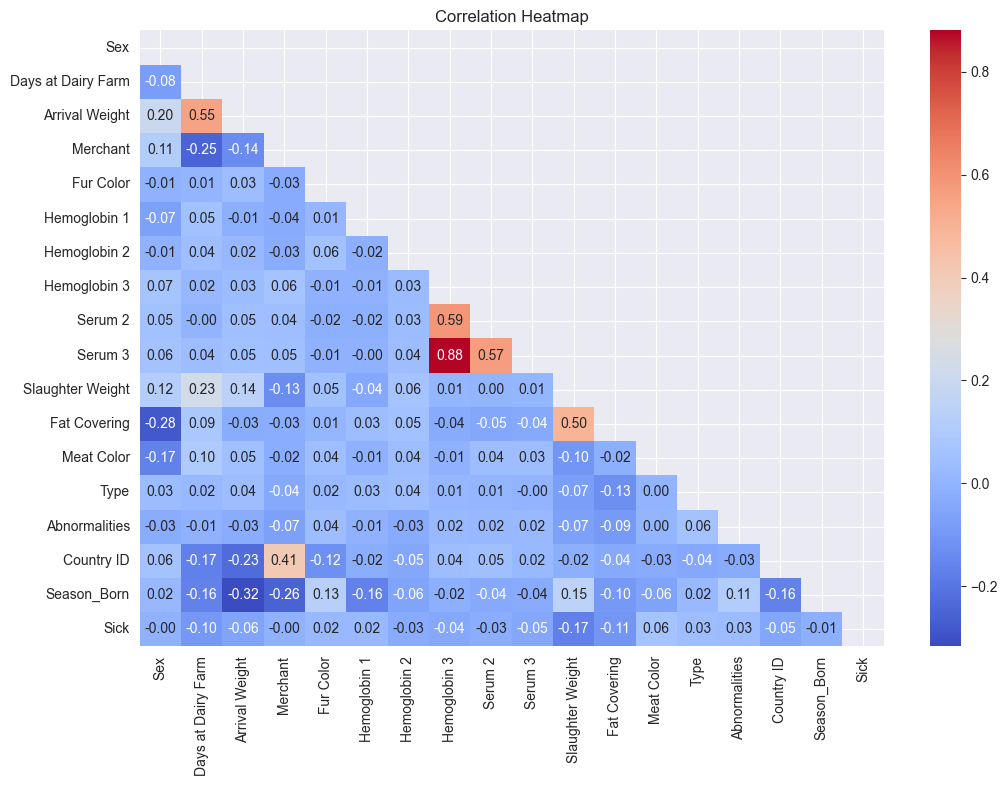

In [675]:
numeric_df = combined_df[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                          'Merchant', 'Fur Color', 'Hemoglobin 1', 
                          'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                          'Serum 3', 'Slaughter Weight', 
                          'Fat Covering', 'Meat Color', 'Type', 
                          'Abnormalities', 'Country ID', 'Season_Born', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

#### Support Vector Machine (Regression) - Data SlaughterhouseP

This code cell performs several key steps to prepare the data, train the model, and evaluate its performance on predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the SVR model**  
   A Support Vector Regression (SVR) model is trained on the scaled training data. SVR is traditionally used for continuous target variables, it is explored here to see if it can help in predicting the `Sick` status, albeit as a regression task. 

5. **Model evaluation**  
   The `R^2` score on the test set is calculated to determine the proportion of variance in `Sick` explained by the model. An `R^2` score closer to 1 would indicate a strong model, whereas values near or below zero suggest weak predictive power. This initial score provides insight into the model's suitability for this task.

6. **Error metrics**  
   Two error metrics are computed: 
   - **Root Mean Squared Error (RMSE)**: Measures the average prediction error, with larger errors penalized more heavily.
   - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions, providing a straightforward measure of model accuracy.

7. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.

In [676]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
Model R^2: 0.01
Root Mean Squared Error (RMSE): 0.37
Mean Absolute Error (MAE): 0.23
Cross-Validation R^2 scores: [ 0.05313737 -0.00749324 -0.00300162 -0.01651386  0.01707959]
Mean Cross-Validation R^2: 0.01


**Results:**

- **R^2 score**:  
  The score of 0.01 indicates that the SVR model explains almost none of the variance in the target variable. This low score suggests the model may not be effectively capturing the patterns needed for reliable predictions.
  - Given the limited range of `Sick` (0 to 1), R² may be less informative on its own and should be interpreted alongside error metrics like RMSE and MAE.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.37 and MAE of 0.23 represent substantial prediction errors, especially given the target’s range from 0 to 1. These metrics imply that the model's predictions often deviate significantly from the actual values, reinforcing the limitations in predictive accuracy indicated by the low R^2.
  - In this context, the errors are large relative to the target range, which suggests that the model might not be suitable for this regression task without further tuning or alternative approaches.

- **Cross-validation R^2 scores**:  
  The cross-validation scores, ranging from -0.016 to 0.05 with a mean of 0.01, are consistently negative. This indicates that the model performs poorly across different data folds, which highlights a lack of generalizability and further suggests that SVR may not be the most appropriate model for this prediction task.

In [677]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

      Actual  Predicted
1743       0   0.088620
217        0   0.082296
1007       0   0.095038
1865       0   0.106294
651        0   0.090913
1986       1   0.148158
2066       1   0.189033
39         1   0.023423
199        1   0.100413
277        1   0.866602


#### Logistic Regression (Classification) - Data SlaughterhouseP

This code cell prepares the data, trains a class-balanced **Logistic Regression** model, and evaluate its performance in predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. By defining `Sick` as the target, the goal is to predict whether or not an observation is classified as "sick" based on other factors. 

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the logistic regression model**  
   A Logistic Regression model with `class_weight='balanced'` is used to account for class imbalance. This configuration assigns a higher weight to the minority class, potentially improving the model’s ability to correctly predict the "sick" class.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **ROC AUC Score**: The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) score measures the model’s ability to distinguish between the "sick" and "not sick" classes. An AUC score ranges from 0 to 1:
      - **1** indicates perfect discrimination, where the model accurately distinguishes between all "sick" and "not sick" cases.
      - **0.5** suggests no discriminatory power, equivalent to random guessing.
      - **Values closer to 1** indicate stronger model performance in correctly classifying cases, with higher scores representing a better balance between true positive and false positive rates across all possible thresholds.
   - **Confusion matrix**: Shows true positives, true negatives, false positives, and false negatives, providing insight into prediction errors.
   - **Classification report**: Displays precision, recall, and F1-score for both classes, essential for evaluating performance on imbalanced data.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The average cross-validation ROC AUC score serves as an indicator of the model’s consistency.

In [678]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])

print(f"ROC AUC Score: {roc_auc:.2f}")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
ROC AUC Score: 0.63
Confusion Matrix:
 [[228 145]
 [ 34  42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.61      0.72       373
           1       0.22      0.55      0.32        76

    accuracy                           0.60       449
   macro avg       0.55      0.58      0.52       449
weighted avg       0.76      0.60      0.65       449

Cross-Validation AUC scores: [0.61535923 0.57773132 0.66767521 0.63516338 0.64480874]
Mean Cross-Validation AUC: 0.63


**Results**

- **ROC AUC score**  
  The ROC AUC score of 0.63 indicates moderate discrimination ability.

- **Confusion matrix**  
  The confusion matrix reveals that the model correctly identifies 228 "not sick" cases (class 0) but misclassifies 145 "not sick" cases as "sick" (class 1). Additionally, it identifies 42 "sick" cases, but there are 34 false negatives, indicating some challenges in detecting the "sick" cases accurately.

- **Classification report**  
  - **Class 0 ("not sick")**: Precision of 0.87 and recall of 0.61, indicating strong precision in predicting "not sick" cases, but with a moderate recall, meaning the model misses a notable number of actual "not sick" cases.
  - **Class 1 ("sick")**: Precision of 0.22 and recall of 0.55, showing that while the model has moderate recall in identifying "sick" cases, its precision is low, resulting in many false positives.

- **Cross-Validation AUC scores**  
  The cross-validation AUC scores range from 0.58 to 0.67, with a mean AUC of 0.63. This variability suggests that further tuning or an alternative model may be necessary to achieve higher stability and reliability in predicting the "sick" class.

In [679]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

      Actual  Predicted
1743       0          0
217        0          0
1007       0          0
1865       0          1
651        0          0
1986       1          0
2066       1          1
39         1          0
199        1          0
277        1          1


#### Linear Regression (Regression) - Data SlaughterhouseP

This code cell prepares the data, trains a **Linear regression** model, and evaluates its performance in predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the linear regression model**  
   A Linear Regression model is fitted on the scaled training data. The goal is to learn the relationship between the features and the target variable.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **R² Score**: Indicates how well the model explains the variance in the target variable. Values closer to 1 suggest better performance.
   - **Root Mean Squared Error (RMSE)**: Measures the average magnitude of the errors between predicted and actual values, providing insight into model accuracy.
   - **Mean Absolute Error (MAE)**: Represents the average absolute difference between predicted and actual values, giving a straightforward measure of prediction error.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.

In [680]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
Model R^2: 0.04
Root Mean Squared Error (RMSE): 0.37
Mean Absolute Error (MAE): 0.27
Cross-Validation R^2 scores: [0.02046749 0.00715721 0.04463991 0.01919496 0.0333001 ]
Mean Cross-Validation R^2: 0.02


**Results:**

- **R² score**:  
  The R² score of 0.04 indicates that the linear regression model explains only 4% of the variance in the target variable `Sick`. This low score suggests that the model may not be effectively capturing the underlying patterns in the data.
  - Given the limited range of `Sick` (0 to 1), R² may be less informative on its own and should be interpreted alongside error metrics like RMSE and MAE.

- **Error metrics (RMSE and MAE)**:  
  - The **Root Mean Squared Error (RMSE)** of 0.37 and **Mean Absolute Error (MAE)** of 0.27 represent substantial prediction errors, particularly considering that the target variable ranges from 0 to 1. These metrics imply that the model's predictions often significantly deviate from the actual values, which is consistent with the low R² score.
  - In this context, these relatively large errors indicate that the linear regression model may not be optimal for this prediction task, and further tuning or alternative approaches may be necessary.

- **Cross-validation R² scores**:  
  The cross-validation R² scores range from 0.01 to 0.04 with a mean of 0.02. These low scores across different folds show that the model's performance remains consistently weak and lacks generalizability across various data subsets. This further suggests that the linear regression model might not be well-suited for this particular dataset.

In [681]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

      Actual  Predicted
1743       0   0.130168
217        0   0.075623
1007       0   0.171409
1865       0   0.279624
651        0   0.119516
1986       1   0.135877
2066       1   0.227732
39         1   0.163911
199        1   0.157666
277        1   0.340263


# All farms combined analysis

## Combine all the farms in a singular file

In [696]:
all_farms = pd.concat([stagri_df, antens_cows, borne_df_s], ignore_index = True)

all_farms.head()

,Country ID + Calf ID,Country ID,Calf ID,Birth date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sick,Slaughter Weight,Season,Season_Born,Birth Date,Fur Color,Sickness Date,Slaughter Date,Fat,Meat Color,Type
0,DE1406468164,0,1.406468e+09,2021-06-08,0,Stagri,42.0,2021-07-14,46.0,0,0.0,U,6.5,7.1,0.0,0.0,0.0,0,90.40,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN
1,DE1269784656,0,1.269785e+09,2021-06-26,1,Stagri,51.0,2021-07-14,46.0,0,1.0,Z,6.7,6.6,0.0,0.0,0.0,0,165.44,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2,DE1269784653,0,1.269785e+09,2021-06-25,1,Stagri,51.0,2021-07-14,46.0,0,1.0,Z,6.3,6.8,0.0,0.0,0.0,0,161.33,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN
3,DE1269784654,0,1.269785e+09,2021-06-25,1,Stagri,49.0,2021-07-14,46.0,0,1.0,Z,6.6,7,0.0,0.0,0.0,0,138.79,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN
4,DE1406364716,0,1.406365e+09,2021-06-29,0,Stagri,47.0,2021-07-14,46.0,0,1.0,Z,7.0,6.9,0.0,0.0,0.0,0,135.26,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN


## Make stable a numeric value

In [688]:
all_farms['Stable'] = pd.factorize(all_farms['Stable'])[0]

all_farms.head()

,Country ID + Calf ID,Country ID,Calf ID,Birth date,Sex,Stable,Days at Dairy Farm,Arrival Date at Veal Farm,Arrival Weight,Merchant,Fur color,Color Letter,Hemoglobin 1,Hemoglobin 2,Hemoglobin 3,Serum 2,Serum 3,Sick,Slaughter Weight,Season,Season_Born,Birth Date,Fur Color,Sickness Date,Slaughter Date,Fat,Meat Color,Type
0,DE1406468164,0,1.406468e+09,2021-06-08,0,0,42.0,2021-07-14,46.0,0,0.0,U,6.5,7.1,0.0,0.0,0.0,0,90.40,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN
1,DE1269784656,0,1.269785e+09,2021-06-26,1,0,51.0,2021-07-14,46.0,0,1.0,Z,6.7,6.6,0.0,0.0,0.0,0,165.44,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2,DE1269784653,0,1.269785e+09,2021-06-25,1,0,51.0,2021-07-14,46.0,0,1.0,Z,6.3,6.8,0.0,0.0,0.0,0,161.33,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN
3,DE1269784654,0,1.269785e+09,2021-06-25,1,0,49.0,2021-07-14,46.0,0,1.0,Z,6.6,7,0.0,0.0,0.0,0,138.79,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN
4,DE1406364716,0,1.406365e+09,2021-06-29,0,0,47.0,2021-07-14,46.0,0,1.0,Z,7.0,6.9,0.0,0.0,0.0,0,135.26,Summer,0,NaT,NaN,NaT,NaN,NaN,NaN,NaN


## Correlation matrix

In [694]:
all_farms_analysis = all_farms[['Country ID', 'Birth date', 'Sex', 'Stable', 'Days at Dairy Farm', 'Arrival Weight', 'Merchant', 'Fur color', 'Hemoglobin 1','Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3', 'Slaughter Weight', 'Season_Born', 'Sick']]


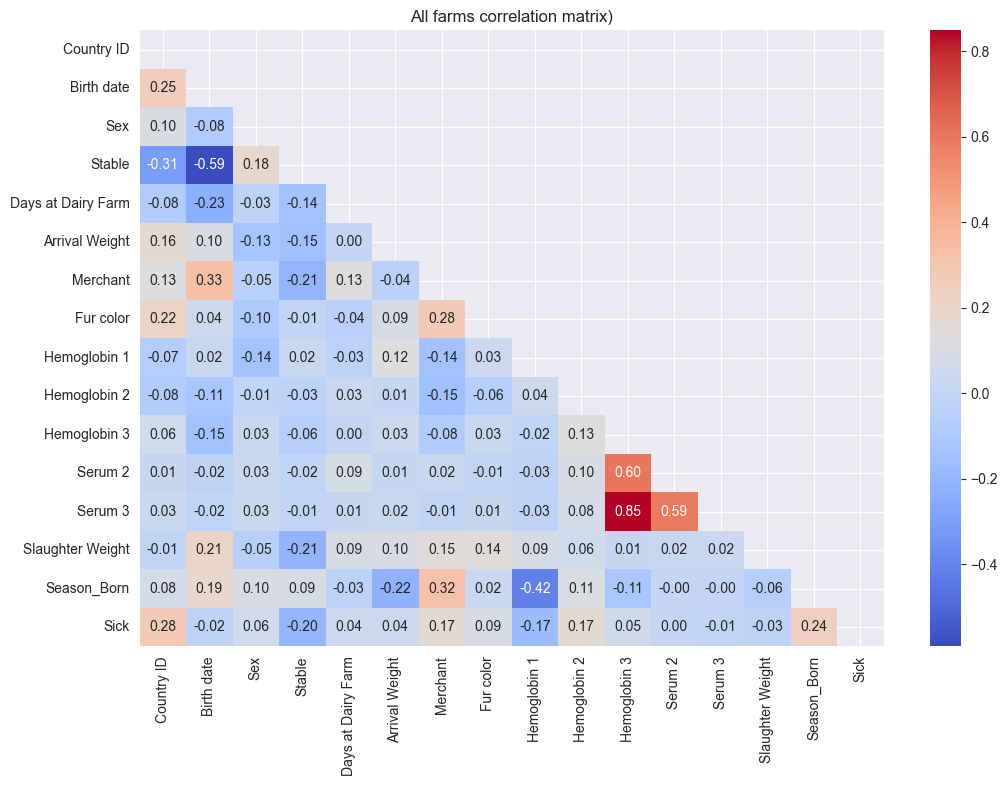

In [695]:
all_farms_corr = all_farms_analysis.corr()

mask = np.triu(np.ones_like(all_farms_corr, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(all_farms_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("All farms correlation matrix)")
plt.show()